In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('./nasdaq_d_2012_2022.csv')
df = df.pivot(index="date",columns="tic", values="adjcp")
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
tick = ['TSLA', 'NVDA', 'AMD', 'AVGO', 'ALGN', 'LRCX', 'FTNT', 
          'ODFL', 'AMAT','MSFT', 'MU', 'IDXX', 'KLAC', 'CDNS', 
          'MRVL', 'ASML', 'FB', 'CTAS','INTU', 'SNPS']
df = df.loc[:,tick]

In [ ]:
#TODO:NOISE 随机扰动
class portOptim(object):
    def __init__(self,real_df,pred_df, dynamic_win = True, tran_cost = 0.001, rf = 0.06):
        self.df = real_df.iloc[1:,:]
        self.date = pred_df.index
        self.pct_dt = real_df.pct_change().iloc[1:,:]
        self.pred_df = pred_df
        self.day = 0
        self.max_day = pred_df.shape[0]
        self.covWin = 30
        self.data = self.df.iloc[self.day:self.day+self.covWin,:]
        self.init_action = self.action = np.array([0]*20)
        self.mu = 0
        self.cov = 0
        self.risk_re = 0.5
        self.dynamic_win = dynamic_win
        
        #portfolio
        self.p = lambda A: self.asset + np.append(-A.sum()-abs(A).sum()*self.tran_cost,A)

        #weight
        self.w = lambda A: (self.p(A) / np.sum(self.p(A)))

        #Penalties for handling fees
        self.pena = lambda A: abs(A).sum()/self.p(A).sum()
        
        #sharpe ratio
        self.SR = lambda A: (self.mu@self.w(A)-self.pena(A))/np.sqrt(self.w(A)@self.cov@self.w(A))
        self.op = lambda A: -self.SR(A)


        ones = np.ones(21)
        self.cons = ({'type': 'ineq', 'fun': lambda A: self.w(A)},
                {'type': 'eq', 'fun': lambda A: self.w(A) @ ones - 1})
        
        self.tran_cost = tran_cost
        self.rf = rf/365
        self.asset = self.weight = np.array([1/21]*21)
        self.scaler = MinMaxScaler(feature_range=(-30,-5))
        self.action_memory = []
        self.asset_memory = []
        self.tick = np.array(tick)
#         print(f'Day{self.day}, initial portfolio {self.asset} , total {round(self.asset.sum(),2)}')
        
    
    def get_mu(self):
        cov = np.array(self.data.cov())
        var = cov.diagonal().reshape(20,1)
        win_s = self.scaler.fit_transform(var).astype('int').flatten()
        pred_c = np.array(self.pred_df.iloc[self.day,:]/self.df.iloc[self.day+self.covWin-1,:])
        mu = []
        for i in range(len(win_s)):
            pct_c = self.data.iloc[win_s[i]:,i]
            mu.append(pct_c.mean())

        dynamic_mu = np.append(self.rf,np.array(mu*pred_c-1)/(win_s+1))
        normal_mu = np.append(self.rf,np.array(self.data.mean()+pred_c/self.covWin))

#         print(f'Var\n{var.squeeze()}\n winSize\n {win_s}\n mu \n{dynamic_mu}')

        return dynamic_mu if self.dynamic_win else normal_mu
        
    def optim(self):
        result = minimize(self.op, x0=(self.action), method='trust-constr', constraints=self.cons)
        return result.x
                      
    def step(self):
        if self.day>=self.max_day:
            print('Finished.')
            return True
        self.data = self.pct_dt.iloc[self.day:self.day+self.covWin,:]
        self.mu = self.get_mu()

        cov = self.data.cov()
        self.cov = np.block([[0,np.zeros(20)],[np.zeros([20,1]),cov]])

        #get the action for achive the SR maximum
        self.action = self.init_action
        self.action = self.optim().astype('float64')
        SR = self.SR(self.action)

        self.action_memory.append(self.action)
#         print(f'Action:\n {self.action}')
        real_c = np.array(self.df.iloc[self.day+self.covWin,:]/self.df.iloc[self.day+self.covWin-1,:])
#         print(f'Real return {real_c}')
        self.asset = self.p(self.action)*np.append(1+self.rf,real_c)
        self.asset_memory.append(self.asset)
#         print(f'Asset:\n {self.asset}')
        #calculate the real asset
        self.weight = self.asset/self.asset.sum()
        self.day+=1
        top_3_idx = self.weight[1:].argsort()[-3:][::-1]
        top_3 = self.tick[top_3_idx]
        print(f'Day{self.day}, {self.date[self.day-1]}, SR {SR}, risk free {round(self.weight[0],2)} TOP3 {top_3},################ total {round(self.asset.sum(),2)}')
        print('#######################################################')
        return False
        
    def perf(self):
        while(1):
            done = self.step()
            if done:
                break

In [ ]:
lag = 0
df_pred = pd.read_csv("./prediction.csv", index_col=0).iloc[lag:,:]
df_real = df.loc['2019-11-15':,:].iloc[lag:,:]
# model = portOptim(df_real,df_pred,dynamic_win = True)

In [ ]:
model.perf()

Var
[5.50040931e-04 3.13397456e-04 5.50664446e-04 1.96216136e-04
 1.11193675e-04 2.59406672e-04 1.27276814e-04 1.10473701e-04
 3.63561500e-04 3.53189593e-05 4.44188464e-04 1.11783783e-04
 3.93506009e-04 2.16147096e-04 4.21834652e-04 1.00955815e-04
 1.15776930e-04 9.19828316e-05 2.08327357e-04 2.26564296e-04]
 winSize
 [ -5 -16  -5 -22 -26 -19 -25 -26 -14 -30 -10 -26 -12 -21 -11 -26 -26 -27
 -21 -20]
 mu 
[1.64383562e-04 2.50060775e-01 6.62288047e-02 2.49538063e-01
 4.76090165e-02 3.99594773e-02 5.51681172e-02 4.16178981e-02
 4.00014861e-02 7.65001519e-02 3.44203619e-02 1.10926934e-01
 3.99952881e-02 9.06151330e-02 5.00247738e-02 9.96808180e-02
 3.98395162e-02 3.99417891e-02 3.84077408e-02 4.99694433e-02
 5.25564168e-02]
Action:
 [ 4.19264723e-04  1.84248303e-08  1.95260389e-04  1.65411683e-09
  5.53451885e-08  3.49459449e-08 -4.36251957e-10  2.25310925e-09
  8.15438897e-09 -4.39651001e-10  1.35743935e-08  2.72613049e-07
  1.35059790e-08  1.69520306e-08  6.10947301e-09 -4.28525486e-09
 

Action:
 [7.81177857e-07 2.52047084e-09 1.09740299e-07 2.05091898e-07
 4.66335714e-07 4.58503545e-09 4.03982054e-06 9.79685729e-07
 1.15355892e-09 3.83470920e-07 1.08315933e-04 8.79848528e-07
 3.27990532e-09 1.00929133e-11 4.27835029e-07 2.88596134e-07
 6.91057729e-07 7.09456110e-07 2.80256697e-07 2.30399253e-07]
Real return [0.97805499 1.01098268 1.0238344  0.99196764 1.03685318 0.99319925
 1.00712594 1.02293452 1.0063331  1.01249312 0.99634916 1.02304185
 0.99332097 1.01494192 1.00191925 0.9983105  1.01431095 1.01478501
 1.00936317 1.01926503]
Asset:
 [0.00250377 0.05641437 0.04928428 0.10027669 0.04474636 0.05049022
 0.04677913 0.05065725 0.04478506 0.04456808 0.04944252 0.064461
 0.05016927 0.04188698 0.05130894 0.04694349 0.04422262 0.05062489
 0.05103346 0.04992503 0.04919873]
Day6, 2020-01-09, SR 6.9926803770007595, risk free 0.0 TOP3 ['AMD' 'MU' 'TSLA'],################ total 1.04
#######################################################
Var
[4.79034440e-04 1.99317952e-04 5.92025

Action:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Real return [0.99033752 1.01368246 1.02512876 1.01289827 1.03987593 1.02550773
 1.01742839 1.0141701  1.02066853 1.01832333 1.02688281 1.00495692
 1.01680534 1.01556846 1.05726056 1.00333231 1.00280357 1.00656976
 1.01417597 1.01203434]
Asset:
 [0.06398402 0.09862889 0.05135324 0.10192791 0.04485589 0.00915324
 0.04803815 0.00026785 0.04677487 0.04545477 0.05071722 0.09437694
 0.05593251 0.04317495 0.05109916 0.05081743 0.04418084 0.05143695
 0.05235443 0.00409881 0.05337178]
Day11, 2020-01-16, SR 7.212294635824701, risk free 0.06 TOP3 ['AMD' 'TSLA' 'MU'],################ total 1.06
#######################################################
Var
[7.86786300e-04 1.67556501e-04 5.88654039e-04 2.28890287e-04
 3.38230263e-04 1.95217000e-04 1.17013279e-04 7.85439602e-05
 1.93083400e-04 6.80619401e-05 5.90137023e-04 9.97618888e-05
 1.70061896e-04 1.27186166e-04 6.24018307e-04 1.17540506e-04
 1.40183899e-04 5.93948489e-05 1.10

Action:
 [ 8.06630708e-02  4.82118774e-10 -6.17938060e-08 -3.32658626e-02
 -2.40202584e-04 -1.87854178e-07 -4.70375234e-03  5.45192053e-03
  3.05360542e-05 -6.93668442e-03 -5.14980449e-08  2.85460665e-03
 -8.08020585e-08 -6.57792861e-03 -2.91866472e-09  1.03228522e-03
  6.20607033e-03  8.95875311e-06  4.18746869e-05 -4.15704137e-02]
Real return [0.98710236 0.99058758 0.97369947 1.01360873 0.99704562 0.98117915
 0.99092969 0.99561783 0.97041791 0.98992339 0.97567562 0.98205665
 0.98274462 0.98886242 0.97466089 1.00513037 0.99171827 0.99097959
 0.99826755 0.99412749]
Asset:
 [1.06621852e-04 4.96418743e-01 5.26822462e-02 1.03301915e-01
 2.16061139e-02 3.89023347e-03 5.19680010e-02 2.09489330e-03
 1.31901681e-02 4.45883671e-02 1.61623665e-02 9.90303243e-02
 1.01458068e-02 4.29462858e-02 2.80821377e-02 5.63216317e-02
 1.11393960e-02 6.61620700e-03 6.92358337e-03 4.77404371e-03
 1.39229328e-02]
Day16, 2020-01-24, SR -1.8559241641065458, risk free 0.0 TOP3 ['TSLA' 'AMD' 'MU'],################

Action:
 [-7.27361188e-03  2.05500134e-04  1.83203477e-03 -1.26079603e-03
  8.20681221e-03 -1.36767664e-03  1.58373737e-03 -3.89313475e-04
  7.55099705e-04  8.09460702e-05  8.22032093e-02 -4.28160302e-04
  7.51401666e-04 -1.56891210e-03 -2.06430963e-03  2.81096262e-04
 -8.31662903e-02  8.99745554e-05  2.10316912e-03 -2.48161004e-05]
Real return [1.01523069 0.96184032 0.96350966 0.96814724 0.97797555 0.95902881
 0.97490069 0.96375458 0.96248961 0.98524152 0.96474652 0.95516864
 0.95847796 0.98564785 0.9693549  0.95339362 0.96363292 0.9850635
 0.97819472 0.97805322]
Asset:
 [2.97851982e-05 9.33665128e-01 1.96517342e-03 3.13273986e-03
 2.80922552e-04 9.70215947e-03 5.25612345e-04 2.67967413e-03
 1.10254923e-03 2.10644452e-03 2.07150759e-03 2.18845792e-01
 1.09418173e-03 2.10522275e-03 2.57030307e-04 1.70289607e-05
 1.32107939e-03 1.76293636e-04 1.81843160e-03 3.10356793e-03
 1.40845991e-03]
Day21, 2020-01-31, SR 1.3242611958989525, risk free 0.0 TOP3 ['TSLA' 'MU' 'ALGN'],################ 

Action:
 [-0.41923242  0.01689773  0.01501861  0.00960041  0.00538568  0.02469304
  0.00980818  0.01214528  0.05130854  0.01079526  0.02372597  0.04031373
  0.08159347  0.01214334  0.01134914  0.0567396   0.00788218  0.00764382
  0.00687427  0.01189961]
Real return [0.99881163 0.98953774 1.00831305 0.98604901 0.96967313 0.97490114
 0.96521882 1.01257734 0.97657874 1.00141597 0.96932518 0.99191214
 0.96133679 0.98671857 0.93281549 0.98520451 1.00701919 0.99295087
 1.00169941 0.99683398]
Asset:
 [0.00263645 1.00503424 0.0170331  0.01552154 0.01016789 0.00563114
 0.02558205 0.00981963 0.01295419 0.05049496 0.01122429 0.02330913
 0.04223105 0.0811666  0.01222719 0.01073937 0.05846731 0.00800667
 0.00780144 0.00716818 0.01577978]
Day26, 2020-02-07, SR -8.750805605677185, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'ASML'],################ total 1.43
#######################################################
Var
[3.92381148e-03 3.18559681e-04 5.80253072e-04 3.15184722e-04
 5.62399056e-04 4.82953916e-04 2

Action:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Real return [0.99506215 1.07020471 1.0143041  0.98086241 1.00725358 0.99332528
 1.0007557  0.99520129 0.99228147 1.00892714 0.98601046 1.01308546
 0.98634729 0.99381706 0.99603502 0.99700555 1.00487939 1.00932586
 1.02165583 1.01227001]
Asset:
 [5.78715853e-03 1.29965143e+00 8.29863604e-03 7.67645388e-03
 2.47892732e-02 2.09732986e-02 2.59105642e-03 6.64754215e-03
 1.19365618e-02 4.31087978e-03 6.68691116e-03 7.71382120e-03
 1.85801000e-02 6.39299853e-04 8.03649514e-03 7.85110464e-03
 4.71340290e-02 1.77942639e-02 7.88378997e-03 8.15081320e-03
 2.31100264e-03]
Day31, 2020-02-14, SR 4.04313262613218, risk free 0.0 TOP3 ['TSLA' 'ASML' 'AVGO'],################ total 1.53
#######################################################
Var
[3.87349882e-03 5.07204733e-04 5.14967812e-04 3.25352181e-04
 6.08094559e-04 5.15112056e-04 2.33289464e-04 2.68917782e-04
 4.86784961e-04 2.09484723e-04 6.89982467e-04 2.09271582e-04
 5.841002

Action:
 [ 4.74154034e-01 -2.14999655e-02  2.33205006e-04  4.57496461e-04
 -2.48366385e-03 -3.50343102e-01 -1.24697408e-03 -5.37787553e-05
 -1.37486259e-04 -1.84569855e-02 -2.23017857e-08  1.10857517e-04
  2.32684375e-04 -5.59033390e-02 -5.33403606e-04  1.90104341e-04
 -4.25132440e-03  2.52327526e-04 -2.27651324e-02  6.05238467e-04]
Real return [0.9254051  0.92930267 0.92192192 0.95763557 0.92257739 0.94842185
 0.94951078 0.97236584 0.9503657  0.95688462 0.96525706 0.97015574
 0.95413347 0.95530572 0.93982792 0.94901942 0.954991   0.98227425
 0.96256319 0.9772986 ]
Asset:
 [4.33863800e-03 1.45282109e+00 2.01048613e-03 6.08245513e-03
 4.75489571e-03 1.96925677e-05 1.78789430e-04 2.34475092e-04
 9.48116775e-03 1.00761750e-03 1.98994564e-04 6.87084101e-03
 1.74511342e-03 1.63497968e-03 1.95863767e-03 2.11834979e-03
 6.30483822e-03 9.59110200e-04 1.86790097e-03 1.53991094e-03
 3.94102202e-03]
Day36, 2020-02-24, SR -5.661665158817972, risk free 0.0 TOP3 ['TSLA' 'ODFL' 'MU'],################

Action:
 [-0.06771156  0.02065301  0.03282193  0.00237518 -0.00171356 -0.00956429
  0.01054224 -0.00853821  0.01745057 -0.00135637  0.00305209  0.00299683
  0.04264045  0.00223473 -0.00952853 -0.00989344  0.00016091  0.00110386
  0.00088028 -0.02893416]
Real return [1.11322019 1.02354928 1.04353561 1.04530131 1.05436224 1.02351505
 1.0787772  1.03240456 1.03509971 1.06653926 1.03862244 1.02938979
 1.03272392 1.03356518 1.03098581 1.03895747 1.0206266  1.04821162
 1.05766412 1.02682529]
Asset:
 [2.87831324e-04 8.63432932e-01 2.32815282e-02 8.93426073e-02
 1.21514062e-02 5.76946658e-05 6.64390576e-04 1.32784650e-02
 6.10903425e-04 2.86501242e-01 6.72038604e-04 3.20034254e-03
 5.07466887e-03 4.52701820e-02 1.40257428e-02 1.29520659e-05
 6.19427619e-04 2.14664765e-04 3.14408282e-03 3.29054746e-03
 5.05284733e-05]
Day41, 2020-03-02, SR -0.8108700289824426, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'AMD'],################ total 1.37
#######################################################
Var
[0.0052

Action:
 [ 4.96664060e-02  3.28237363e-03  1.84302531e-04  3.70643951e-03
 -3.97257490e-02  3.56991393e-03  1.95438547e-04 -4.93385914e-03
 -5.55516195e-04 -1.40999896e-02  3.73598063e-03 -1.26102858e-02
  1.73351478e-09  1.35956552e-06  1.42376869e-03  4.38106527e-03
  2.07802324e-04  1.54255678e-03  7.35092066e-08  1.93627699e-05]
Real return [1.06139799 1.06372225 1.04876359 1.06127894 1.05220442 1.0746261
 1.04108334 1.04986236 1.07874017 1.06838399 1.04111384 1.05159988
 1.06658859 1.05305436 1.0445543  1.06005836 1.05126845 1.07008463
 1.03699423 1.05865314]
Asset:
 [1.40375742e-04 1.06224425e+00 3.84221504e-03 5.81294189e-03
 4.62785232e-03 1.18191170e-04 4.05131685e-03 5.89133803e-03
 5.31669355e-05 2.73870729e-04 5.14517485e-04 3.91573445e-03
 1.13745605e-04 3.32841503e-02 1.20582491e-02 9.89601068e-03
 1.89906134e-02 5.13151555e-04 1.74421796e-03 6.07098683e-03
 2.52342925e-02]
Day47, 2020-03-10, SR 1.5267203271369059, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'SNPS'],###############

Action:
 [ 0.06675354  0.05178296  0.02497526  0.03972244  0.00037006 -0.00047057
  0.04215999  0.00754569 -0.15778572  0.00089708  0.00637317 -0.00675134
 -0.14303348 -0.0020242  -0.00320968  0.02373444  0.02220704  0.00110977
  0.01329467  0.02115109]
Real return [0.96658954 1.10626273 1.08189104 1.06359939 1.04656195 1.07380365
 1.03064729 1.0581403  1.10683445 1.08233644 1.08442119 0.96448199
 1.15544391 1.07948718 1.06087945 1.03915246 1.02335459 1.03264034
 1.07044708 1.06093129]
Asset:
 [0.00189948 0.40921139 0.06417977 0.04207163 0.05269305 0.00545803
 0.01269939 0.05750507 0.0195453  0.01538219 0.00762947 0.0196137
 0.00269263 0.00203391 0.00402194 0.00855276 0.03667677 0.02665811
 0.00664872 0.02611533 0.03841174]
Day52, 2020-03-17, SR -9.756186139400382, risk free 0.0 TOP3 ['TSLA' 'NVDA' 'FTNT'],################ total 0.86
#######################################################
Var
[0.00571542 0.00435859 0.00369633 0.00295107 0.00304723 0.00353153
 0.00246021 0.00167102 0.00

Action:
 [-3.81211574e-02  1.60331157e-02 -2.91161044e-02 -2.64708973e-02
  3.94318430e-03  2.54741032e-02 -6.21728596e-02 -1.45546439e-03
  1.10425833e-01  6.76094051e-03 -1.69053803e-02  1.13726734e-03
  8.30097329e-03  6.15131152e-03 -4.51651211e-04 -2.88225008e-03
 -6.08072968e-03  1.04823974e-03 -3.26367429e-05  3.83374153e-03]
Real return [1.16281745 1.17156426 1.10999044 1.09970552 1.20011616 1.20312979
 1.1615832  1.09315713 1.12372431 1.09089567 1.13124196 1.12053134
 1.17188026 1.13390618 1.15295378 1.11606267 1.08696819 1.10658352
 1.20080104 1.11200215]
Asset:
 [1.34124632e-03 7.16269625e-01 2.06852477e-02 4.06734828e-05
 2.66364506e-02 1.14171536e-02 3.15091999e-02 5.02602925e-04
 1.82476062e-04 1.24173796e-01 8.49638560e-03 3.09978475e-04
 2.68332209e-03 9.98445997e-03 8.21087852e-03 1.35066154e-02
 6.98522498e-05 2.04008768e-03 2.36156910e-03 1.42503290e-04
 6.20837686e-03]
Day57, 2020-03-24, SR -3.2109666071554903, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'LRCX'],#############

Action:
 [ 2.48020208e-05  1.05656093e-03 -1.26742241e-04 -6.22450796e-05
 -7.24663265e-04 -3.31878157e-02 -1.48888965e-03 -2.03837886e-03
 -2.70609115e-05 -1.26542827e-05  1.23948379e-03 -3.01485365e-03
 -2.07332069e-06 -2.07453220e-04 -2.20053665e-06 -6.43855121e-03
 -6.57723907e-03 -4.70727565e-04 -8.68844394e-06 -1.17043352e-03]
Real return [1.04355446 0.99250724 0.9502716  0.98746407 0.96681858 0.9400705
 1.00217931 0.97467882 0.96871064 0.98427245 0.94474397 1.00506183
 0.96134294 0.98699742 0.99691632 0.97615945 1.00512206 0.95993343
 0.96618355 0.99597862]
Asset:
 [8.39479787e-02 7.83051898e-01 1.08936673e-03 1.66905518e-02
 2.10459036e-05 9.04362166e-05 4.90424716e-04 1.24938759e-02
 8.95604012e-04 4.03383229e-02 9.46356067e-03 1.31430606e-03
 1.02010676e-03 1.78200372e-02 8.87411734e-03 1.34494252e-02
 1.93098592e-04 4.61788579e-04 1.30503406e-02 1.64544047e-02
 1.81866279e-04]
Day62, 2020-03-31, SR 2.863911658143397, risk free 0.08 TOP3 ['TSLA' 'AMAT' 'KLAC'],###############

Action:
 [-1.03218978e-07  1.26687161e-05 -7.90692367e-06  7.58271861e-05
  9.78699831e-08  1.49586514e-03 -6.54236449e-05  7.74078895e-04
  1.77266862e-04  1.63685534e-06  1.26983901e-07  1.84113925e-04
  4.64387004e-04  5.08682514e-08 -1.32986345e-05 -1.73536077e-05
  1.19931392e-04 -2.21578604e-04  6.59778747e-05  4.19020531e-04]
Real return [1.05658216 0.9650894  1.00084177 1.00328789 0.9876089  1.02181455
 0.98896927 1.03227661 1.03055253 0.98922989 1.00366623 0.9894274
 0.99171746 0.99467019 1.00125849 1.00538487 1.01981274 1.03571241
 0.99850064 0.99705681]
Asset:
 [0.00466887 0.8064793  0.00732301 0.00456496 0.00748662 0.03619613
 0.03048765 0.01203283 0.00635557 0.01356834 0.00550488 0.00708396
 0.00495442 0.05725765 0.00554007 0.00526695 0.00968678 0.01181278
 0.01157401 0.00462391 0.00880319]
Day67, 2020-04-07, SR 2.7681394090509084, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'ALGN'],################ total 1.06
#######################################################
Var
[0.0075248  0

Action:
 [-1.26239781e-01  1.95446848e-02  3.14816796e-02  8.43807138e-03
  2.09666117e-03  3.44569401e-03  5.00325640e-03 -4.30307924e-03
  9.40913102e-03 -3.73472279e-03 -4.68833257e-03 -7.15249018e-03
 -8.32267813e-04 -1.84441663e-03  3.37910461e-02  1.03791073e-04
  1.21709259e-03  7.80421146e-03  2.04646611e-02  5.40075078e-03]
Real return [1.02808891 0.9890474  1.00109232 0.96192504 0.96752633 0.9644051
 1.00457247 0.99445663 0.95997725 0.98952213 0.97501062 0.9802669
 0.94738136 0.9917463  0.98511554 0.97771081 0.99326488 0.92746658
 0.96418178 0.99145361]
Asset:
 [1.88228629e-03 6.67758571e-01 2.96018807e-02 3.67893542e-02
 2.11853971e-02 2.08369149e-03 4.24229373e-01 9.54625003e-03
 4.30603631e-04 9.23437502e-03 2.55490770e-03 2.43199572e-03
 2.16995875e-03 3.65923024e-03 3.53019683e-03 4.21121936e-02
 7.38352549e-03 2.11111505e-03 7.30598103e-03 2.46105700e-02
 1.08957849e-02]
Day72, 2020-04-15, SR -0.230897489761965, risk free 0.0 TOP3 ['TSLA' 'LRCX' 'MRVL'],################

Action:
 [-0.44737315  0.02646684  0.02117703  0.0491595   0.05144822 -0.00063905
  0.01918969  0.03881932  0.04917123  0.02176467  0.02594246  0.03678675
 -0.11830051  0.02187315  0.02306188  0.05127691  0.03891077  0.02467727
  0.0273514   0.03859162]
Real return [1.06609683 1.06174157 1.05668934 1.04974768 1.01479229 1.11554411
 1.03093494 1.03285803 1.07821221 1.03396491 1.06037189 1.03429381
 1.06790486 1.0698486  1.0541929  1.04937917 1.06721309 1.0364304
 1.05900054 1.04059656]
Asset:
 [9.52806929e-05 3.53550191e-02 3.16772308e-02 2.63867098e-02
 5.29341374e-02 6.00119112e-02 5.88963004e-01 2.04375980e-02
 4.01268997e-02 6.29388985e-02 2.31586749e-02 3.19837306e-02
 3.88526225e-02 6.48013681e-02 2.53416551e-02 2.49903205e-02
 5.54950575e-02 4.16642721e-02 2.57158883e-02 2.96785220e-02
 4.22132142e-02]
Day77, 2020-04-22, SR -10.150963367927066, risk free 0.0 TOP3 ['LRCX' 'KLAC' 'AMAT'],################ total 1.32
#######################################################
Var
[0.0070

Action:
 [ 4.10609733e-02  3.37409161e-03 -1.79262595e-02 -3.44918864e-03
 -1.37764730e-04  3.34657225e-03 -8.73740166e-03 -7.01079458e-05
  1.64686829e-04 -1.06259538e-02 -1.98849797e-02  4.78190030e-04
  1.77906827e-02 -9.72835146e-03  6.14096605e-03 -1.39077900e-03
 -1.32176759e-05 -3.24697036e-04 -1.02417204e-03  4.77722180e-03]
Real return [1.04081287 1.02436836 0.9666727  1.04264716 1.08387798 1.06927642
 1.02921087 1.02851394 1.07774705 1.04487383 1.09975726 1.03212863
 1.05785775 1.04498533 1.03236614 1.0421728  1.06166967 1.0585781
 1.02673576 1.04070337]
Asset:
 [0.00104224 0.15832218 0.03659181 0.0081754  0.05408828 0.07450414
 0.72308209 0.01411987 0.04202999 0.06515771 0.00295944 0.00784001
 0.00836752 0.02577522 0.01555508 0.006439   0.05526608 0.00377979
 0.02940831 0.01404355 0.05014907]
Day82, 2020-04-29, SR 1.1034555933771912, risk free 0.0 TOP3 ['LRCX' 'TSLA' 'ALGN'],################ total 1.4
#######################################################
Var
[0.00537974 0.

Action:
 [ 0.03639298  0.09919977  0.00618425 -0.0409204   0.20974236 -0.24151815
 -0.0170042  -0.04039625 -0.00090265  0.00331096  0.00827152  0.00546407
 -0.05139187  0.04374761  0.00514983 -0.04801392  0.002457    0.05124145
  0.01458884 -0.04572442]
Real return [1.01870588 1.01378773 0.9994252  0.99739497 1.03508936 1.00720732
 1.02671335 0.99121323 1.03377694 1.00984735 1.01475442 1.00535313
 1.05256041 1.01656834 1.01256193 1.01231132 1.00676097 0.99729534
 1.00506388 1.01679199]
Asset:
 [1.33551036e-03 4.01862516e-02 1.34058732e-01 6.26309408e-03
 3.18641692e-03 2.22953152e-01 6.07674609e-01 5.23265156e-04
 3.19481904e-03 5.63798581e-02 1.65386753e-02 1.21344246e-02
 9.72414277e-03 6.90536712e-05 6.48310499e-02 6.53304719e-03
 3.62741021e-03 8.50218591e-03 6.44846890e-02 1.58679820e-02
 3.20024156e-03]
Day87, 2020-05-06, SR -10.70350506513747, risk free 0.0 TOP3 ['LRCX' 'ALGN' 'NVDA'],################ total 1.28
#######################################################
Var
[0.0033

Action:
 [-8.21041831e-02  5.94562385e-03  1.10700996e-02 -4.82437447e-04
  5.61271000e-02 -5.22027733e-01  3.46663126e-04  9.15614420e-03
  2.32775710e-02  3.00790995e-03  7.39896750e-02  7.96108418e-03
  3.99014296e-01  4.35155142e-03  7.04366169e-04  1.64231138e-03
  3.25124442e-03  2.38216303e-03 -2.89405292e-03  2.75435768e-03]
Real return [1.01563922 1.03219769 1.04465309 1.01311069 1.02542542 1.08384726
 1.00656164 0.99057233 1.05709851 1.00433953 1.05053992 1.03146963
 1.07728392 1.01049381 1.01939497 1.02827713 1.00833735 1.14658848
 1.01122079 1.01043537]
Asset:
 [1.38715716e-03 6.38357551e-01 6.55677510e-03 1.15669190e-02
 4.89668731e-04 5.91326264e-02 1.21362928e-03 4.18291493e-03
 9.99436286e-03 2.62870425e-02 4.02701765e-03 1.01426434e-01
 9.32534812e-03 4.31031387e-01 4.71550860e-03 1.01314674e-03
 3.07536718e-03 3.38328959e-03 2.80111360e-03 2.83879879e-03
 2.79938735e-03]
Day93, 2020-05-14, SR -16.53665486721692, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'MU'],################

Action:
 [-2.44595738e-07 -2.41567299e-04  4.74427501e-04  3.34149291e-03
  3.43281015e-03  1.04898425e-05  2.63411727e-02  4.61087376e-03
 -2.86000422e-02  2.73917185e-04  1.51344444e-03  3.76613742e-03
 -9.28592980e-03  1.51946966e-04  1.98458563e-03  2.03770810e-03
  4.52676652e-03  2.18724851e-03  2.96469907e-03  2.02505859e-03]
Real return [1.01476289 0.97828872 0.9691435  0.98607702 0.99974579 0.96138933
 0.98461756 1.00257242 0.96729968 0.9879887  0.96955397 0.99025511
 0.96914328 0.97752304 1.00483425 0.97957865 1.00617471 1.00843983
 0.9983133  1.01825107]
Asset:
 [0.01624727 1.16943891 0.00526489 0.00550107 0.00567816 0.00571536
 0.02052177 0.02896016 0.00739172 0.01001153 0.00561969 0.00620672
 0.00628359 0.00857608 0.00530879 0.0046521  0.00462035 0.01644602
 0.00574648 0.00461928 0.0046358 ]
Day98, 2020-05-21, SR 3.405917075191659, risk free 0.01 TOP3 ['TSLA' 'FTNT' 'LRCX'],################ total 1.35
#######################################################
Var
[0.00250235 

Action:
 [ 4.40647607e-01  1.33748737e-04  1.04542362e-04  5.47255535e-04
  4.55357590e-04 -4.47680944e-01  1.22862720e-04  3.95944180e-04
  5.40569002e-04 -5.76527709e-04  2.37985909e-04  4.11209918e-04
  1.25500659e-03 -3.72967947e-05  2.71890452e-04  4.51651718e-04
  3.70443044e-04  4.87451766e-04  3.50520089e-04 -4.65927395e-05]
Real return [1.0362244  1.04577594 1.03981441 1.02871369 0.98571315 1.02567277
 1.03363777 1.03203033 1.0276202  1.01019848 1.03098765 1.00898311
 1.00773151 1.03667958 1.08842187 1.02981536 0.99835886 0.98506276
 1.02272163 1.03941396]
Asset:
 [8.96850403e-04 1.17230996e+00 6.38142966e-04 5.96029672e-04
 6.52347680e-04 1.43436379e-03 2.01890299e-01 1.32100042e-04
 4.35206050e-04 1.36324859e-03 4.16349186e-04 8.75189058e-04
 4.67260889e-04 1.32844850e-03 4.65166334e-04 4.63770950e-04
 6.08158428e-04 4.82312124e-04 7.09022553e-04 5.59120045e-04
 5.09865262e-04]
Day103, 2020-05-29, SR -13.979183622017134, risk free 0.0 TOP3 ['TSLA' 'LRCX' 'ALGN'],############

Action:
 [ 9.54345839e-04 -1.09090641e-04 -5.27441411e-04  2.66397830e-03
 -1.67657806e-04 -6.02314640e-02  7.70616158e-04 -4.97258243e-04
  4.33872743e-02 -2.20452452e-04  1.06766025e-03 -1.73993388e-04
  4.96910117e-03  7.26149247e-04  3.80760978e-03 -1.72618460e-03
 -3.45987006e-05  9.71176078e-04  8.18195109e-04  7.80620379e-05]
Real return [1.02461878 1.0175099  1.00893022 1.02651421 1.10820157 1.04481925
 1.00644787 1.02223708 1.03543773 1.02339847 1.04880906 1.00525672
 1.03322773 1.0014244  1.         1.01163942 1.01979765 1.06422499
 1.0183443  1.00285012]
Asset:
 [4.33691613e-03 1.10597427e-03 6.86576700e-04 3.86136925e-04
 6.01647402e-03 1.08006876e-03 1.46256750e+00 1.07473812e-03
 5.52441268e-04 7.49040472e-02 6.63741862e-04 1.68382101e-03
 7.26943430e-04 9.97130491e-03 8.03528352e-04 4.06469477e-03
 8.47147666e-04 1.56194533e-03 1.17763016e-03 1.13621860e-03
 1.69193974e-03]
Day108, 2020-06-05, SR 0.9180423967658057, risk free 0.0 TOP3 ['LRCX' 'AMAT' 'KLAC'],#############

Action:
 [-0.00026545 -0.00130763 -0.00012136 -0.00174321  0.04392991  0.00301427
 -0.00031484  0.00056349 -0.03762964 -0.00010998  0.01550738  0.00023885
 -0.00762535 -0.0002959  -0.00025089 -0.00289135 -0.00176635 -0.00605136
 -0.00169194 -0.00065647]
Real return [0.96139142 1.01548961 1.01268215 1.02212775 1.05506125 1.00739988
 0.98944812 1.00400647 1.02057387 1.00789179 1.00350369 1.01345333
 1.02276013 1.01187643 1.01230501 1.03058062 1.01849133 1.00833333
 1.01011248 1.00044564]
Asset:
 [1.80933475e-04 5.09789761e-03 3.84811745e-04 3.76367637e-04
 2.57629297e-04 6.79939758e-02 1.36775400e+00 2.62278091e-03
 1.48748440e-03 1.29133076e-05 7.04197394e-04 1.61371063e-02
 1.46739300e-03 3.86817864e-03 6.31265994e-05 2.02126726e-04
 1.00290515e-04 8.18574024e-04 8.80108902e-04 1.44115965e-03
 8.25581968e-04]
Day113, 2020-06-12, SR 0.7309598869494607, risk free 0.0 TOP3 ['LRCX' 'ALGN' 'MU'],################ total 1.47
#######################################################
Var
[0.00163

Action:
 [-1.66344453e-03  4.04160566e-03  2.20456321e-03  4.71767922e-03
 -1.90686901e-04 -4.49492753e-02  1.20420996e-03  3.96653228e-03
  3.24304346e-04  1.79862429e-03  6.07491201e-05  5.08743967e-03
  5.06419000e-03  2.65489600e-03  2.26736847e-03  5.23186695e-04
  3.21569257e-03  7.34891975e-08  2.96411838e-03  3.55540501e-03]
Real return [0.996952   1.004692   1.00351589 0.95977298 0.98601723 1.00142964
 1.00788858 1.02143554 1.0094402  0.99404036 1.00693345 1.00527131
 0.99669653 0.98047582 0.98521312 1.00498779 1.0120793  0.97951483
 0.99683186 0.97140295]
Asset:
 [3.68871760e-03 6.39290049e-04 4.21419764e-03 3.63430331e-03
 5.50493919e-03 1.02118506e-01 1.21769711e-01 1.94753805e-03
 5.71804283e-03 6.03066064e-02 2.99028227e-03 5.64860710e-01
 5.90677539e-03 5.89324804e-03 2.66804286e-03 3.05056725e-03
 5.36736974e-03 4.42292584e-03 6.79847511e-01 3.04130401e-03
 4.12503579e-03]
Day118, 2020-06-19, SR 0.9001916472432346, risk free 0.0 TOP3 ['CTAS' 'MU' 'LRCX'],###############

Action:
 [-2.99113172e-02  2.96649727e-03 -1.58676848e-03 -3.12106709e-03
  5.96977108e-04 -3.09310776e-03  2.03520804e-03  4.70998656e-03
  5.59234588e-07  6.49411630e-04  3.44802229e-04  1.36719802e-03
  3.83721524e-03  2.77715662e-03  1.63868862e-04  6.72496933e-04
 -5.99239112e-03  2.00703234e-03  1.90602475e-03  1.75090530e-02]
Real return [0.97338688 0.96469957 0.96476022 0.99533744 1.02218087 0.96775427
 0.99057646 0.99993845 0.97332449 0.97998421 0.98576952 0.99227212
 0.98554703 1.01273465 0.98110426 0.98693228 0.91683642 0.9768825
 0.99227706 1.00384836]
Asset:
 [2.23607821e-03 9.97596683e-03 3.89675881e-03 1.10992624e-05
 7.56337473e-05 6.28054773e-04 5.98984778e-01 3.04544214e-03
 5.17084594e-03 1.21848670e-01 1.67742371e-03 6.55601030e-01
 5.14174338e-03 6.89708095e-02 2.97581841e-03 1.88410610e-04
 3.72359841e-03 5.54802427e-04 2.27625969e-02 2.93752991e-03
 1.76731094e-02]
Day123, 2020-06-26, SR 0.22395693714666595, risk free 0.0 TOP3 ['MU' 'LRCX' 'AMAT'],###############

Action:
 [-3.01163428e-03  4.60802980e-04  4.93067863e-02  2.05202013e-02
  3.55127485e-02 -3.06629813e-01  1.52358293e-03  1.55210406e-04
  1.87134705e-01  5.64817903e-03 -2.55341931e-02  1.01538740e-03
  1.15118712e-02  9.64138337e-04  6.06957914e-04 -2.66345684e-04
  1.39266105e-03  1.02168616e-02  7.09761842e-03  1.30026888e-06]
Real return [1.13479397 1.0236159  1.02025222 1.01052407 1.00896656 1.03478536
 1.00910138 1.02932066 1.04032796 1.02152615 1.02187443 1.01406976
 1.03602863 1.00940501 1.03255285 1.03279568 1.02938909 1.01101076
 1.01424817 1.00916083]
Asset:
 [1.85714467e-03 4.01754435e-03 5.20988756e-04 5.03231405e-02
 2.07436764e-02 1.20601408e-01 7.80279452e-02 1.53949997e-03
 4.56408099e-04 1.95952331e-01 5.77649234e-03 1.10956406e+00
 1.23934069e-03 1.19591033e-02 9.99638600e-04 7.91786733e-04
 3.76195781e-05 1.43781027e-03 1.04865006e-02 7.44364425e-03
 1.73329418e-04]
Day128, 2020-07-06, SR -11.379892114553058, risk free 0.0 TOP3 ['MU' 'AMAT' 'ALGN'],##############

Action:
 [-1.35413083e-02  6.61587280e-03  2.99860951e-03  4.19825161e-05
  3.05010172e-03 -1.12820793e-05  5.16079676e-04  1.86772499e-03
  1.39664336e-04  8.56564300e-05  1.00722886e-08 -2.38227459e-03
  1.07822758e-04 -3.50197611e-03  2.31709442e-03  9.91682997e-05
  4.64044586e-04  8.76845192e-05  4.98362664e-04  5.87173697e-04]
Real return [0.96919041 0.95925284 0.95901931 0.97454913 0.98883963 0.99164664
 0.89931408 0.97405012 0.98274488 0.96911122 0.97554237 0.99080566
 0.98670047 0.97266513 0.95719122 0.98173544 0.97523154 0.99805136
 0.96777778 0.98050603]
Asset:
 [0.01053366 0.00045475 0.00967517 0.00331018 0.11216547 0.10464754
 0.11550968 0.0821381  0.10100262 0.11602833 0.09645308 0.16934983
 0.00670909 0.10825372 0.0066017  0.12380812 0.10346341 0.09723587
 0.11429451 0.10556484 0.0042234 ]
Day133, 2020-07-13, SR 1.0204326515486812, risk free 0.01 TOP3 ['MU' 'MRVL' 'AMAT'],################ total 1.59
#######################################################
Var
[0.00226372 

Action:
 [-6.59260341e-05 -7.46559661e-05  9.79686063e-04  3.16111461e-05
 -9.12516907e-06 -1.16497445e-04 -3.24164846e-05  2.04490666e-05
 -3.82767026e-05 -1.18393573e-04 -7.30467674e-04 -1.18914671e-05
 -3.22560620e-05 -3.01099191e-06  3.47252383e-06  3.50303759e-06
 -1.30344381e-05 -6.42034380e-06 -8.58217031e-04 -1.75617739e-03]
Real return [0.95457088 0.98266059 0.99199445 0.99120222 1.00754061 1.00924382
 0.99161667 0.99920039 1.0012553  0.98653116 1.00605342 1.00642661
 1.00246286 0.99884286 0.98481546 0.98043332 0.98504605 1.02253258
 0.99718814 0.98905403]
Asset:
 [0.00316064 0.16368393 0.01531471 0.02175033 0.11286185 0.15584605
 0.12213222 0.00806533 0.10685713 0.11978507 0.07552779 0.17566958
 0.02050521 0.10043652 0.00724644 0.12116162 0.09657417 0.09820706
 0.08639344 0.0346132  0.00736502]
Day139, 2020-07-21, SR 3.4940580001185415, risk free 0.0 TOP3 ['MU' 'TSLA' 'ALGN'],################ total 1.65
#######################################################
Var
[0.00237614 0

Action:
 [-7.00927859e-01 -7.77864865e-03 -2.44171674e-02  5.48658846e-03
 -1.87046716e-04 -8.96501418e-03  8.56037862e-01 -2.47901922e-03
 -9.78757241e-04  8.93104025e-04 -3.44695793e-02 -1.66453370e-02
  3.61221224e-03  3.84581216e-03 -9.40090027e-02  1.39059231e-02
 -7.42352934e-04 -9.83958968e-03 -2.92846187e-02  4.52679961e-02]
Real return [0.95900881 0.98023335 0.98028127 0.9829538  0.96877728 0.97444687
 0.976363   0.98440282 0.98873195 0.99102282 0.97092457 0.98630916
 0.97665801 0.98841081 0.98313659 0.9858033  0.9855246  0.98417585
 1.00219464 0.98888831]
Asset:
 [5.94672408e-04 6.48625023e-01 4.21325770e-04 4.41222331e-04
 8.36339200e-03 2.29180499e-04 4.27666827e-04 8.59802175e-01
 2.23502389e-04 9.94275504e-05 2.35962302e-02 5.85093658e-04
 2.14451533e-04 7.06556336e-03 4.26296415e-03 7.40611309e-04
 1.61593556e-02 8.55336904e-04 3.35310709e-04 3.52621993e-05
 4.79777820e-02]
Day144, 2020-07-28, SR -31.635262824600936, risk free 0.0 TOP3 ['FTNT' 'TSLA' 'SNPS'],############

Action:
 [ 0.14409256 -0.00537585  0.00563508 -0.00752776  0.0014724  -0.01972143
  0.00420134  0.00321816  0.00171417 -0.0024645  -0.00022601  0.00249462
 -0.14287309 -0.00115213 -0.000535    0.00301138  0.00154635  0.00337764
 -0.00208099  0.00288888]
Real return [1.00134678 1.01975439 1.09488867 1.02228914 1.00316677 1.00930748
 1.00441326 1.01419802 0.99753877 0.98499124 1.01805917 0.99556114
 0.9867566  0.97646956 1.00347888 1.01014705 0.99154626 1.00970749
 0.99659926 0.9953156 ]
Asset:
 [0.00797535 1.0088404  0.00913405 0.0062943  0.00594458 0.03264482
 0.02197024 0.0046839  0.00334032 0.00172299 0.00747294 0.01535009
 0.0035894  0.47644235 0.00555763 0.01091916 0.00341729 0.00160488
 0.00396456 0.00492382 0.00308888]
Day149, 2020-08-04, SR 0.08767916563197868, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'ALGN'],################ total 1.64
#######################################################
Var
[0.00258772 0.00048717 0.00238797 0.00017517 0.00099609 0.00052372
 0.0008806  0.00020612 0

Action:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Real return [1.13123643 1.0544009  1.07453178 1.02965779 1.01265908 1.03390166
 1.00086895 1.02341052 1.03164758 1.02856724 1.01507541 1.02887466
 1.03719967 1.01996576 1.01700789 1.03736403 1.01468008 1.00490078
 1.01854934 1.01727389]
Asset:
 [2.02626149e-05 1.30474298e+00 3.58470225e-02 9.92604286e-02
 1.48214798e-02 4.96649803e-03 3.92849591e-02 2.88283252e-02
 8.71239865e-03 7.25535518e-03 3.48782481e-02 2.02944951e-02
 1.10413637e-04 3.39941052e-03 3.76786821e-05 2.49117941e-02
 2.56382221e-02 3.73255747e-03 1.62499890e-02 1.33236691e-02
 6.96963009e-04]
Day155, 2020-08-12, SR 5.312980803265583, risk free 0.0 TOP3 ['TSLA' 'AMD' 'LRCX'],################ total 1.69
#######################################################
Var
[0.00292121 0.00048824 0.00261092 0.00018762 0.0009319  0.00042414
 0.00093396 0.00019043 0.00037553 0.00044385 0.00049171 0.00033457
 0.00055361 0.00023066 0.00046214 0.00056796 0.00061784 0

Action:
 [-0.34657185  0.02985333 -0.00590016  0.011853    0.00526163  0.00776384
  0.0074072   0.01424758  0.04100898  0.0145389   0.00384688  0.00871242
  0.06526366  0.00795701  0.00382787  0.02041237  0.06816051  0.0048155
  0.03371299 -0.00270271]
Real return [0.9954639  0.99002918 0.99301975 1.00173445 0.98510146 0.99364604
 0.99684418 1.00301949 0.99486478 0.99393303 0.99211702 0.98668048
 0.99423873 0.99431972 0.99191142 0.9939558  1.00095296 0.99915302
 1.00534134 0.99065423]
Asset:
 [6.20960077e-03 1.62630900e+00 2.95726470e-02 4.41815026e-04
 1.20206983e-02 5.18921328e-03 8.94440116e-03 8.65947507e-03
 1.45646868e-02 4.10267181e-02 1.58644244e-02 6.41181903e-03
 8.78793955e-03 6.51271403e-02 9.23476119e-03 6.24830156e-03
 2.04861505e-02 6.82281390e-02 5.87449305e-03 3.39061892e-02
 1.70686375e-03]
Day160, 2020-08-19, SR -3.552751755092654, risk free 0.0 TOP3 ['TSLA' 'FB' 'KLAC'],################ total 1.99
#######################################################
Var
[0.002592

Action:
 [-4.80965129e-01  4.93712962e-01 -2.13485510e-02  8.87139352e-04
  6.70678362e-04  1.12889048e-03  2.07684020e-03  6.18635931e-04
  1.16232691e-03  3.06876233e-03  2.55068845e-03  8.01034182e-04
  1.54499206e-04  6.50501921e-04  2.26863093e-03  5.23192700e-04
 -7.76768752e-04 -1.35937374e-02  3.63615825e-03  1.75145915e-03]
Real return [1.06416619 1.00180397 0.99617832 1.01050172 1.01355002 0.99801406
 1.02956184 1.00672847 0.99547219 1.0216195  0.99689578 1.00544369
 1.00927337 1.01267298 1.01136038 1.01336573 1.08222347 1.0037568
 1.01759702 1.01665359]
Asset:
 [1.45621316e-04 1.71929172e+00 4.94604510e-01 3.63690677e-04
 8.98482968e-04 6.81280577e-04 1.13501620e-03 2.14828714e-03
 6.80496138e-04 1.16063620e-03 3.13896600e-03 2.55899428e-03
 8.65051446e-04 1.56180147e-04 6.71555709e-04 2.31123667e-03
 5.31340720e-04 8.84297287e-05 1.37090254e-04 3.71637548e-03
 1.78972417e-03]
Day165, 2020-08-26, SR -7.02861475559678, risk free 0.0 TOP3 ['TSLA' 'NVDA' 'INTU'],###############

Action:
 [-1.06513606e-07 -2.06372951e-04 -1.42799036e-02  1.53842178e-03
  1.96665601e-03  1.48290629e-03  1.58105803e-03  1.50298173e-03
  7.05335696e-04  5.10621194e-04  1.83027580e-04  9.59356321e-04
  5.77046750e-04 -2.33201539e-05 -1.46739406e-03  1.75847054e-03
 -1.65926143e-03  1.20513921e-03 -5.06445784e-04  2.99872256e-03]
Real return [0.94173246 1.03802175 0.97873726 1.04302714 1.06220738 1.06501072
 1.01593627 0.99745257 1.05154309 1.01927214 1.04523603 1.0196241
 1.03649917 1.02728543 1.05103338 1.02995597 1.02389655 1.02108501
 1.02016256 1.01783973]
Asset:
 [1.69527062e-03 3.60994975e-01 9.33856510e-05 1.98290881e+00
 2.49958447e-03 2.59344540e-03 2.01557921e-03 1.67997788e-03
 2.68984981e-03 3.93221614e-03 8.16248740e-04 8.39467004e-04
 1.02315753e-03 5.38581237e-03 4.14409681e-05 2.22599568e-05
 2.86698683e-03 4.96285433e-05 2.00458802e-03 2.38678707e-04
 3.40710129e-03]
Day170, 2020-09-02, SR 4.3438638522732305, risk free 0.0 TOP3 ['AMD' 'TSLA' 'KLAC'],###############

Action:
 [ 3.58123816e-02  1.15352316e-03  5.52073759e-09  8.91970911e-05
  1.91757996e-04  6.75382461e-04 -1.37439044e-02  4.90415298e-04
  2.03727795e-04 -1.17296045e-03  4.62426895e-04 -2.57900358e-02
 -2.21648988e-03  7.27590939e-04  6.14804494e-05  6.72921538e-04
  8.02039121e-04  2.63435334e-05  8.07908998e-07 -2.33492365e-04]
Real return [1.01381456 0.96828547 0.96422903 0.99180626 1.01244134 0.98870093
 0.99701137 0.97754212 0.99855076 0.9719816  0.99379844 0.98289503
 0.9923765  0.97968186 0.97617227 0.99340512 0.97943152 0.97407422
 0.97617401 0.99001606]
Asset:
 [2.01877612e-03 1.99436369e-01 1.36210036e-03 1.35163454e+00
 1.52604038e-03 1.30158561e-03 1.09687260e-03 2.79127077e-03
 3.47699437e-03 2.83103854e-03 1.09662563e-02 1.37870169e-03
 9.49622440e-04 6.51432341e-03 7.70070275e-04 5.20288939e-02
 7.94776450e-04 9.01146607e-04 1.21809721e-03 4.46468815e-01
 1.24045544e-03]
Day175, 2020-09-10, SR 1.0479356921125842, risk free 0.0 TOP3 ['AMD' 'INTU' 'TSLA'],##############

Action:
 [-3.59797413e-02  7.29508928e-04 -7.33287301e-02  5.00862507e-04
  1.88079981e-02  7.94451459e-03  8.31011556e-03  4.60451347e-04
  5.41691021e-04  1.15298133e-02  4.44919455e-03  3.37197143e-04
  4.86614869e-05  4.72079123e-04  1.42266085e-02  2.03133371e-02
  8.60042663e-03  8.37563497e-03  2.04572431e-03  2.79309403e-04]
Real return [0.95850684 0.99592474 0.99856508 0.99694849 0.99445223 0.9976842
 0.98648763 1.00220968 0.99769778 0.98956351 1.01533562 0.97748103
 0.99823017 0.98634811 1.01654385 1.01203158 0.9669855  0.99632126
 0.98037531 0.97582906]
Asset:
 [1.13944715e-03 2.06815588e+00 7.40987336e-04 1.49173591e-03
 5.26846746e-04 1.87382812e-02 7.93382573e-03 8.21808488e-03
 5.07898066e-04 5.99918155e-04 1.14299005e-02 4.52039446e-03
 3.91944909e-04 5.75699933e-05 4.86181559e-04 1.44745853e-02
 2.05682605e-02 8.32926573e-03 8.36332007e-03 2.03466065e-03
 2.84206444e-04]
Day180, 2020-09-17, SR 1.9746023238127837, risk free 0.0 TOP3 ['TSLA' 'ASML' 'ALGN'],##############

Action:
 [ 4.76473208e-01 -5.26729479e-03  1.28552201e-03 -8.17766362e-02
  2.12286346e-03 -8.52437439e-02 -6.50020477e-03 -1.24461503e-01
  4.91550830e-03 -1.26982204e-02 -1.88510520e-02  2.30450810e-03
 -1.37405594e-03 -1.23175843e-02 -5.13922540e-03 -1.68279889e-02
 -8.83476774e-04 -3.62094688e-02  3.06096148e-05 -7.59441088e-02]
Real return [1.05041385 1.04257768 1.02954363 1.01214109 1.01939845 1.00947494
 1.01134197 0.99173607 1.00761365 1.02278661 0.99332921 1.03381943
 1.01826166 1.01566783 1.00395786 1.0008884  1.02119989 1.02677003
 1.03211372 1.03468813]
Asset:
 [3.40309206e-03 1.87570580e+00 1.45685051e-02 1.39021741e-02
 3.15989114e-03 2.30515596e-03 1.41835081e-02 3.10863465e-02
 2.91697453e-03 5.11280415e-03 6.05412001e-05 1.23143037e-02
 7.64427854e-03 4.79980345e-02 7.15464871e-04 3.05597725e-02
 3.88780251e-03 6.51019725e-03 1.09595311e-02 6.04582526e-02
 1.64266525e-04]
Day186, 2020-09-25, SR -3.8669115906900022, risk free 0.0 TOP3 ['TSLA' 'INTU' 'KLAC'],############

Action:
 [ 2.24845063e-01  7.53823447e-04  2.69010164e-03 -4.12407737e-02
 -7.88560775e-03 -3.48953360e-03  1.47253131e-03 -3.85205169e-02
 -5.40016587e-04 -5.99128554e-03 -9.22677168e-03 -2.28603585e-02
 -5.10374571e-05 -6.01665414e-03 -4.36522929e-03 -2.88272289e-03
 -6.65273824e-03 -3.29934115e-03  9.22601378e-04 -7.75752635e-02]
Real return [0.92620937 0.95943656 0.96394064 0.96806845 0.99143613 0.96927427
 0.96781702 1.00979376 0.95976911 0.97048851 0.97141061 0.97231371
 0.96472019 0.96952962 0.98660379 0.96856107 0.97490904 0.97987891
 0.96855617 0.97678385]
Asset:
 [1.57531205e-03 2.08445324e+00 4.13661121e-03 3.06888305e-03
 6.24976645e-04 1.79263946e-03 1.81439950e-04 2.91412463e-03
 6.60800841e-04 1.45507691e-03 2.83167335e-04 3.54119430e-04
 6.32081319e-04 1.32430360e-03 2.87487022e-04 3.58366278e-04
 7.83762201e-02 2.73311983e-05 3.53161312e-04 2.53377323e-03
 6.17372269e-04]
Day191, 2020-10-02, SR 1.7337223236261181, risk free 0.0 TOP3 ['TSLA' 'ASML' 'NVDA'],#############

Action:
 [-9.09576603e-09  4.91535058e-04  9.35554810e-04  8.57094135e-03
  1.60390967e-02  6.69424159e-04  2.96964723e-04 -7.96984565e-03
  1.34252769e-04  4.25457770e-04  3.49646308e-03  2.98899460e-04
 -1.30964398e-02  1.51337957e-03  1.58366273e-03  2.36439381e-05
  4.58828559e-03  6.99856545e-04  1.91387778e-03 -1.00134899e-03]
Real return [1.01897067 0.99450825 0.96058255 1.00902693 1.0032665  1.02048216
 1.03732326 1.01344433 1.01102242 1.02483617 0.99979956 1.01814435
 1.02104599 1.02387487 1.045614   1.02126591 1.00261602 1.00458603
 1.02215933 1.0173036 ]
Asset:
 [2.84734684e-02 1.61859201e+00 1.67947730e-02 2.84214011e-03
 1.16638138e-02 2.24313001e-02 1.53744963e-03 1.90806610e-03
 3.90810285e-05 5.28771442e-01 1.66558549e-03 1.00035054e-02
 1.05596849e-03 3.75099906e-04 1.63320019e-03 1.99854633e-03
 3.92792706e-04 3.64388128e-02 7.49406238e-04 1.57034626e-02
 1.13877085e-05]
Day196, 2020-10-09, SR 3.01165498262322, risk free 0.01 TOP3 ['TSLA' 'AMAT' 'FB'],################

Action:
 [ 1.54060534e-02  1.53219826e-04  6.30073236e-06  6.64043646e-03
  9.53251449e-07  1.00687961e-03  1.28377757e-06  3.30445616e-04
  2.76186756e-09  2.02912472e-05  1.15036623e-03  7.92767850e-06
  7.61751489e-05  1.17851555e-04  1.00378651e-04  8.77023180e-05
 -2.62676961e-02  1.06623112e-05  1.81188933e-04  8.46093827e-04]
Real return [0.97948229 0.98865432 1.00048119 0.99663096 0.99955439 0.97195663
 0.99840602 0.98318702 0.99196976 1.         0.99364659 1.0024366
 0.97799054 0.99767164 1.00023287 1.0008536  0.99703806 1.00005731
 0.99760225 0.99320264]
Asset:
 [0.00474165 0.92006795 0.04923807 0.04636117 0.04860726 0.0461691
 0.04642501 0.04384897 0.03604954 0.39374153 0.04485245 0.04104362
 0.04229566 0.05588939 0.0461082  0.04038522 0.29519988 0.02156511
 0.04120864 0.04318644 0.04644354]
Day201, 2020-10-16, SR 2.6888328193478115, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'ASML'],################ total 2.35
#######################################################
Var
[0.00389781 0

Action:
 [ 6.28223078e-09 -8.93998300e-06 -9.55273739e-03 -3.52533410e-02
  6.52393899e-01 -1.54999476e-02 -2.31405447e-03 -2.97965670e-04
 -3.84196337e-01 -2.44680818e-05 -4.32411252e-02 -2.06783640e-04
 -5.61666382e-02 -4.24698731e-02  6.11021585e-03  5.44262132e-04
 -2.92527962e-02 -3.95366884e-02 -1.96549954e-03  2.56262156e-03]
Real return [0.98788134 1.01715834 1.03198188 0.99825914 1.03603024 0.9885759
 1.01732211 1.02273649 0.98784437 1.00623585 0.97186465 1.01432991
 0.99931145 1.02497259 1.00950297 1.00814912 1.0239825  0.99872971
 1.00783558 1.00697254]
Asset:
 [1.29181605e-03 1.41748831e+00 4.34353640e-02 3.58965383e-02
 2.54585312e-03 6.92653580e-01 2.46771916e-03 4.16833817e-02
 3.55770640e-05 1.40181898e-03 4.36278317e-02 7.66646174e-05
 2.12166074e-03 5.07806960e-04 1.23838481e-03 6.27798043e-03
 3.13539463e-03 9.07320690e-05 2.37555154e-03 9.79032055e-03
 2.82726132e-03]
Day206, 2020-10-23, SR -12.755305459474563, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'MSFT'],#############

Action:
 [-3.40475638e-05  2.08964833e-04  8.23647728e-05 -2.48523415e-05
  1.96637880e-01  2.92442108e-04 -1.69546327e-02 -3.35624608e-05
 -2.21564842e-05  3.40023738e-05 -1.89951157e-02 -1.36349656e-01
  6.23434762e-04  5.62634538e-04  5.11841542e-05  1.30094097e-05
 -2.72782711e-02  4.61108035e-05  1.10081858e-03 -6.00544061e-05]
Real return [0.94452698 0.96237701 0.96500903 0.98484551 0.97597173 0.96835178
 0.93533901 1.00010509 0.9954622  0.98900934 0.99722662 0.96156636
 0.97638031 0.99237822 0.98168024 0.97397942 0.93690132 0.98321434
 0.96643236 0.97448279]
Asset:
 [1.91097584e-04 9.10931432e-02 6.85007088e-02 6.89974544e-02
 5.66473664e-02 1.46585883e+00 2.89943798e-04 1.22204676e-02
 3.56406305e-02 1.84641182e-02 3.44253393e-02 1.39123554e-02
 5.86004834e-04 3.05860929e-03 2.71244259e-02 4.91288174e-02
 4.14969291e-02 2.71391394e-04 4.43706540e-02 5.16272235e-02
 7.07085754e-02]
Day211, 2020-10-30, SR 1.3227568933590939, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'SNPS'],#############

Action:
 [ 2.47990850e-03 -2.80717362e-04 -1.71433178e-04 -8.01293094e-04
  5.13169056e-04  9.47977578e-04 -1.38358914e-02 -5.71273183e-03
 -3.29226565e-03 -8.81261078e-04  5.41994056e-03  1.08401557e-02
  2.51281944e-03 -3.11263603e-05 -1.59791934e-03 -3.62649588e-03
 -1.28509029e-04  1.45930864e-03 -4.70084834e-04 -3.10830642e-03]
Real return [0.98141938 1.02838969 1.03469876 0.99934349 0.97141754 1.02429264
 0.98075472 1.00412279 1.00829159 1.0019257  1.01062656 1.0216467
 1.01569476 1.01152575 1.08799422 1.02021645 0.99569028 1.00548562
 1.00370417 1.0050715 ]
Asset:
 [0.01853787 0.00400475 0.03391482 0.04593082 0.06067696 1.71423138
 0.03360973 0.02511976 0.03752706 0.04200948 0.03759849 0.00770183
 0.11702533 0.00523345 0.03338507 0.05003083 0.03614629 0.0039953
 0.03544463 0.04532535 0.05064359]
Day216, 2020-11-06, SR 3.2853434212382284, risk free 0.01 TOP3 ['ALGN' 'IDXX' 'AVGO'],################ total 2.44
#######################################################
Var
[0.00093147 

Action:
 [ 0.13307979 -0.00159279 -0.00108289  0.01249454 -0.32587728 -0.00267217
 -0.00576435  0.00993497  0.02316454  0.00211488 -0.00269111  0.00794544
  0.02202782  0.00290003 -0.00723414  0.01281421  0.13471448 -0.03527008
 -0.00037577  0.02421602]
Real return [0.99208274 0.9881286  0.99499027 1.00891407 1.00993904 1.01875937
 1.02042253 1.02777912 1.04312308 1.00496666 1.02986672 1.00983931
 1.01609572 1.01099862 1.03990381 1.01664562 1.00679812 1.01810276
 1.02128698 1.01103862]
Asset:
 [9.98957831e-05 1.32255838e-01 3.34277463e-04 8.77402547e-05
 2.53311389e-02 1.88900300e+00 3.39578399e-04 3.42373203e-04
 1.59982334e-02 2.47080551e-02 2.54933514e-03 3.44930365e-04
 3.53654026e-02 2.28191309e-02 3.27086213e-03 3.48327413e-04
 1.59359729e-02 1.35667951e-01 2.48794893e-04 8.81511438e-04
 2.55210768e-02]
Day221, 2020-11-13, SR -2.124849671877645, risk free 0.0 TOP3 ['ALGN' 'FB' 'TSLA'],################ total 2.33
#######################################################
Var
[0.00067

Action:
 [ 7.58257088e-04 -1.25027434e-08  3.27792781e-03  4.60734008e-03
  4.43612794e-01 -8.41212037e-04  3.52553886e-03  7.12549633e-05
  1.20630630e-04 -1.76817554e-04 -4.71637446e-04 -8.38857070e-08
  3.45976792e-05  1.34294929e-03  9.38551927e-04 -1.66119888e-04
 -4.61663511e-01  2.33782809e-03  8.15725592e-04  4.79274737e-04]
Real return [0.98065174 0.97377274 0.98947859 0.99739809 1.01155547 0.99076955
 1.00931389 1.00043788 0.99313932 0.99044353 0.99304546 1.01552966
 0.99515905 1.00168741 0.99502029 1.00054324 0.9881293  0.98358189
 0.96195763 0.9874819 ]
Asset:
 [9.67118499e-04 4.98446164e-03 7.32821087e-01 4.02569693e-03
 4.93383993e-03 1.24781396e+00 3.96748484e-03 3.95429885e-03
 2.29478120e-03 3.21445524e-03 5.77089535e-03 1.45567075e-03
 2.20137029e-01 5.75341316e-03 2.60722188e-03 2.41981013e-03
 1.31847076e-02 1.23800493e-03 2.93651471e-03 3.68143517e-03
 1.74322154e-02]
Day226, 2020-11-20, SR -6.215753982573893, risk free 0.0 TOP3 ['ALGN' 'NVDA' 'IDXX'],#############

Action:
 [ 0.05606098  0.14482973  0.10341995  0.02911503 -1.1263796   0.00231169
  0.09801742  0.00866542  0.06127808  0.07359938  0.04898429  0.05447229
  0.04053635  0.02423618  0.1779402   0.00623478  0.09826027  0.00715366
  0.0594516   0.02980592]
Real return [0.96899748 1.01057601 1.06273656 1.01678686 1.01217667 0.99150122
 0.99547623 1.00678254 0.99782234 0.99461036 0.99782021 1.01486031
 0.99150042 0.99759823 1.02615811 0.99990874 0.99697636 0.9839652
 0.99373302 1.00922723]
Asset:
 [3.40210661e-04 7.45293426e-02 1.62836823e-01 1.27711119e-01
 3.59728636e-02 9.84462441e-01 1.82955922e-02 1.14066689e-01
 1.56937439e-02 7.85797127e-02 8.69284014e-02 6.34421691e-02
 5.63861722e-02 5.77163641e-02 4.00403586e-02 1.99565342e-01
 1.38453761e-02 1.30540354e-01 2.10716858e-02 6.34912183e-02
 3.75363553e-02]
Day231, 2020-11-30, SR -25.34655562126094, risk free 0.0 TOP3 ['ALGN' 'MRVL' 'NVDA'],################ total 2.38
#######################################################
Var
[0.0014

Action:
 [ 2.29087483e-01  2.23299957e-03  1.63738491e-03 -1.07456286e-03
  6.86198546e-08 -1.25194237e-02 -4.86279327e-02 -9.67319488e-03
 -5.02006906e-08 -1.98514234e-02 -3.25389708e-02 -1.38215657e-07
 -4.09779437e-02 -8.75552387e-08  4.10633436e-04 -8.89470728e-03
  9.51648359e-08 -4.14526612e-03 -2.91920828e-04 -5.43031300e-02]
Real return [1.07131416 1.00357718 1.000319   1.02237175 0.99231398 1.01740055
 1.00219091 0.99440853 1.0033767  0.9996733  0.99004636 1.00483428
 1.01137659 1.00574616 1.01751952 1.01149903 1.02102243 0.97157948
 1.00973943 1.00966731]
Asset:
 [7.09917242e-04 3.22303033e-01 2.49894949e-03 1.68893237e-03
 4.99704109e-02 1.85004506e+00 1.22755222e-02 1.89201325e-04
 1.00730539e-02 3.68414960e-02 5.73782084e-03 3.62530793e-04
 3.90258810e-02 1.35422412e-04 2.20342866e-02 3.63230325e-02
 1.32010166e-02 6.89050864e-02 2.27951447e-02 2.36454609e-02
 6.34854010e-03]
Day236, 2020-12-07, SR -4.839116459436707, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'FB'],###############

Action:
 [-0.79067609  0.05070297  0.04598234  0.0018632   0.24684795  0.05367698
  0.06079814  0.02813788  0.02060136  0.03861045  0.04367929 -0.0190642
  0.02056656  0.03355307  0.04239775 -0.00193266  0.01120661  0.07349954
  0.04668185  0.00104302]
Real return [1.04891888 1.02270763 1.03415163 1.01473548 0.99453737 1.00034583
 1.01815209 0.97290712 1.00226496 1.00440786 1.01432016 1.00425225
 1.00970384 1.02354034 1.03237079 1.00079529 1.00233966 0.99470106
 1.00326638 1.01044884]
Asset:
 [2.09041711e-04 1.08393798e+00 6.16745492e-02 5.61658633e-02
 2.62520329e-02 7.30083459e-01 6.01035909e-02 6.20338085e-02
 2.83179669e-02 2.07102985e-02 4.81752671e-02 4.86966095e-02
 1.86579078e-02 2.07868989e-02 5.18725248e-02 5.37282970e-02
 3.36654020e-03 1.24851804e-02 8.11886803e-02 5.46992918e-02
 3.92619565e-03]
Day241, 2020-12-14, SR -21.61309930427887, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'CTAS'],################ total 2.53
#######################################################
Var
[0.0015

Action:
 [ 4.41746583e-01 -8.52873606e-03 -3.71670516e-02  1.79492560e-03
 -2.00671127e-01 -5.24028127e-02 -8.34395566e-03 -5.25550789e-03
 -7.48112852e-03 -4.71506982e-02  3.12007729e-03 -4.18885155e-03
 -2.91601300e-05 -1.83128208e-02 -9.91350569e-05 -8.75110133e-03
 -1.98900861e-02  7.23847993e-05 -2.64646712e-04 -2.74515405e-02]
Real return [0.93505034 1.0045396  0.97195585 0.98692929 1.00149086 1.00469882
 1.0007542  0.99138025 1.00371713 1.01829907 1.00014008 1.00856814
 0.9947358  0.9978033  0.99452757 0.989565   0.98693927 0.97680266
 0.98900313 0.99701963]
Asset:
 [3.97437257e-03 1.71371939e+00 4.67738689e-02 2.71966669e-02
 1.84944870e-03 5.54681055e-01 8.92757865e-05 5.86941690e-02
 2.75596040e-02 1.21435437e-02 9.85853368e-03 3.86238808e-03
 4.13295713e-03 1.80354704e-02 1.27004427e-03 6.60296615e-02
 1.58263438e-03 6.52525991e-03 2.83428122e-03 1.17371438e-02
 7.13199035e-05]
Day246, 2020-12-21, SR -5.200514364530749, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'MRVL'],#############

Action:
 [-4.22287882e-01  9.15426977e-03  2.22615775e-02  1.99970880e-04
 -2.19194500e-03 -1.18581793e-02 -2.39059730e-01  1.19052632e-03
  2.90251272e-01  8.87922366e-03 -9.09510436e-03  2.44524821e-04
  5.11311305e-01 -1.18590223e-02  1.48769637e-01  2.02956353e-02
 -3.64485984e-01 -1.24761604e-02  5.77067683e-02 -1.34605329e-03]
Real return [1.00346545 1.00335274 0.98930136 0.9934242  0.99921289 0.99395076
 0.9882109  0.99599818 0.99293032 0.99639924 0.99363148 0.99872649
 0.98749903 0.99421194 0.9840359  1.00785027 0.99920577 0.9807448
 0.99267949 0.9908651 ]
Asset:
 [2.37612674e-03 1.48341470e+00 1.69423165e-02 2.32804669e-02
 2.40523112e-04 1.42663861e-06 1.59635023e-03 1.29055616e-03
 1.45649202e-02 2.88606333e-01 1.06000512e-02 1.47945280e-03
 7.35536191e-03 5.04988396e-01 1.37664836e-03 1.47514579e-01
 2.33083977e-02 1.86558707e-03 1.31827692e-03 6.92872187e-02
 3.90942534e-03]
Day251, 2020-12-29, SR -23.552452041291296, risk free 0.0 TOP3 ['TSLA' 'KLAC' 'AMAT'],#############

Action:
 [-0.45529194  0.03184844  0.01869041  0.02213137  0.0066714   0.04373822
  0.07829384  0.0349357   0.02185388  0.02050268  0.0260618   0.00628155
  0.00563529  0.01335182  0.06035043  0.02761779  0.02534503  0.02640079
  0.02385541 -0.03868922]
Real return [1.0283903  0.94104703 0.97369845 0.99383318 0.99400348 1.00392279
 0.97438969 1.00808346 1.01372772 0.97407072 0.99805847 0.97252945
 0.99781797 0.95960041 0.97689561 0.97004119 0.97173117 1.00601908
 0.9786646  0.96450223]
Asset:
 [1.41536857e-03 2.26339222e+00 3.24853257e-02 3.15366099e-02
 4.98693908e-02 6.95008421e-03 4.67418520e-02 7.63568785e-02
 3.86006787e-02 2.29296958e-02 2.05447991e-02 3.72600978e-02
 8.29547525e-03 3.91718341e-02 2.79311448e-02 6.70978020e-02
 4.99745651e-02 2.69062456e-02 2.89425129e-02 2.33990076e-02
 6.61712267e-04]
Day256, 2021-01-06, SR -5.00824761811221, risk free 0.0 TOP3 ['TSLA' 'FTNT' 'MRVL'],################ total 2.9
#######################################################
Var
[0.00132

Action:
 [-2.74211263e-12  4.15392254e-03 -9.47943999e-02  1.63347319e-02
 -1.56292320e-04  2.21055464e-03  5.47966416e-03 -1.54457833e-03
 -1.46317113e-05  2.16130097e-03 -4.18139913e-08  1.03948039e-02
 -1.06391702e-02 -1.16765947e-03  5.77325298e-03  1.45159902e-02
 -3.50387697e-06  2.15168565e-03  1.00923681e-06 -5.69756007e-05]
Real return [1.00585088 1.00348533 0.96245803 1.00404987 0.99685286 0.98147035
 0.96723557 0.98824695 0.98040186 1.00656024 1.00566332 1.00171114
 0.99694147 1.00299128 0.99210115 1.00025286 1.00219046 0.98921838
 0.99805824 0.99443123]
Asset:
 [4.69049435e-02 1.90916835e+00 6.29582845e-03 5.38793170e-04
 1.64901364e-02 1.79038074e-01 6.90045351e-03 5.96387571e-03
 3.88281917e-02 5.51580678e-04 6.00401086e-03 1.77225621e-01
 1.62031798e-02 1.30672932e-02 1.51079329e-01 6.44819574e-03
 1.62301543e-02 4.52576972e-01 6.94349219e-03 2.37110438e-02
 1.12203995e-01]
Day261, 2021-01-13, SR 3.8647918570603164, risk free 0.01 TOP3 ['TSLA' 'FB' 'ALGN'],##############

Action:
 [-7.40986495e-10 -1.17140372e-03  1.62987461e-03  1.65064428e-03
  1.90967781e-03  2.65023642e-03 -9.55803868e-04 -1.87183765e-04
 -1.73668635e-03 -3.81196272e-04  4.34488667e-03  1.47218077e-03
 -9.31856201e-04 -2.51678162e-03  2.95532229e-03 -1.25732446e-04
 -8.51330087e-05 -1.18277416e-03  1.54783226e-03 -1.37517559e-02]
Real return [0.99357984 1.03753987 1.03132393 1.0106955  0.96357    1.00211355
 0.99647349 0.99406591 1.00120552 1.00280824 1.01808388 1.00282804
 1.00285875 0.98943604 0.98909016 1.0388801  1.02015098 0.99768213
 0.98020345 0.99795195]
Asset:
 [8.32157849e-03 2.38728944e+00 2.06007011e-02 3.26957806e-03
 4.23489848e-03 4.36496716e-03 4.24578042e-03 4.31862163e-01
 1.57249346e-02 4.53176083e-02 1.24359349e-02 4.46335812e-03
 4.11340216e-03 1.09887795e-01 2.48549159e-02 4.16209458e-03
 3.72224751e-02 3.54131008e-02 5.16670893e-04 3.92174635e-03
 1.90665623e-03]
Day266, 2021-01-21, SR 5.6320396408274025, risk free 0.0 TOP3 ['TSLA' 'FTNT' 'KLAC'],#############

Action:
 [ 0.0840623   0.02946886 -0.03033892  0.02222023  0.00024215 -0.00038523
 -0.14416304  0.02690788  0.04242846  0.04779607  0.11135     0.06192296
 -0.16891386 -0.00639246 -0.12825214 -0.02633734  0.00327279  0.02387584
 -0.02276845  0.07484574]
Real return [0.96675386 1.01031507 0.98514183 1.01583094 1.05286085 0.98506912
 1.0185845  1.02413423 1.02607017 1.02589091 1.04394747 1.03673846
 1.0234144  1.0351943  1.02033627 1.04305894 0.97376345 1.01954756
 1.01883734 1.01819041]
Asset:
 [4.22642429e-03 2.00383073e+00 3.99118343e-02 1.79760706e-02
 2.38371038e-02 3.79889599e-03 1.73855758e-04 4.17726065e-01
 3.29088498e-02 4.57367773e-02 4.99897246e-02 1.17690121e-01
 6.73814470e-02 5.24700313e-03 1.74909923e-02 1.60076792e-01
 2.24548694e-03 8.27698305e-03 2.53491825e-02 1.29333484e-02
 7.94749389e-02]
Day271, 2021-01-28, SR -5.811607441688779, risk free 0.0 TOP3 ['TSLA' 'FTNT' 'MRVL'],################ total 3.14
#######################################################
Var
[0.001

Action:
 [-3.94202827e-05  9.38174760e-04 -8.11454405e-05 -2.97827882e-04
 -1.18231101e-04  1.62798096e-06  1.21051387e-04  6.12329373e-04
 -1.13012340e-01  8.04465276e-03  1.23286606e-02  3.38173822e-03
  1.84300182e-02  3.39399501e-03 -1.27067642e-01 -2.93884570e-04
 -4.87810624e-02  2.91474268e-05  8.09401518e-04 -8.73128507e-04]
Real return [0.99450092 1.0098853  0.99943107 1.01169418 1.12629533 1.03013902
 1.04022003 1.03342601 1.03374376 0.99592596 1.027051   1.01780125
 1.02769829 1.01691143 0.9841519  1.02307928 0.99939995 1.02005367
 1.03309222 1.01840053]
Asset:
 [2.42240502e-01 2.28956314e+00 2.24161174e-02 9.47841340e-02
 5.91653572e-03 5.09461244e-02 1.45909949e-01 1.28490892e-01
 6.76861098e-03 1.88930466e-04 1.88698257e-02 3.20089917e-02
 4.30570947e-03 4.77175830e-02 4.78667224e-02 1.31249189e-02
 3.96008814e-03 2.32727715e-04 2.80564838e-02 1.97693602e-02
 3.23889663e-04]
Day276, 2021-02-04, SR 2.9305103836949127, risk free 0.08 TOP3 ['TSLA' 'LRCX' 'FTNT'],############

Action:
 [ 3.16177716e-02 -2.26347736e-02 -2.06667637e-02  3.77119481e-03
 -1.13767097e-05 -2.02732074e-02  4.34127372e-05 -5.91733906e-06
  8.75596706e-08  7.97679533e-03  4.26441279e-03 -1.36753999e-02
  8.00428517e-03 -4.67301116e-03  4.55405006e-02 -5.89999252e-03
  1.19081965e-03 -3.31598958e-03  4.98754141e-04  1.92354158e-03]
Real return [1.00849875 1.03295131 1.00335685 1.0177429  0.98880777 1.07457277
 1.01047599 0.99545429 1.06724581 1.0068775  1.05015178 1.02309597
 1.09028592 1.04432033 1.0300456  1.04342989 0.99455629 0.97935401
 1.02902169 1.03550409]
Asset:
 [1.40549038e-03 2.00979454e+00 2.42111903e-03 2.52008542e-03
 7.21201628e-03 9.33726412e-02 4.71774147e-03 2.15343006e-02
 2.76701027e-01 4.72442209e-01 3.34521497e-02 6.70416743e-02
 7.83656431e-05 9.07347063e-03 2.04239500e-02 5.38622600e-02
 1.68733660e-04 3.16739596e-03 1.84197778e-02 2.47070265e-02
 5.12641544e-02]
Day281, 2021-02-11, SR 4.44909087859131, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'ODFL'],###############

Action:
 [ 4.04763672e-01 -5.61910763e-03  3.69551585e-04 -4.88229109e-03
  1.65229869e-03 -4.81622735e-05 -4.26312734e-03  9.34580415e-04
 -2.86351479e-01 -2.31708413e-02 -3.61898229e-03 -9.14827631e-03
 -2.38859255e-02 -5.12212903e-03 -4.24991420e-03 -4.58434996e-03
 -1.10848961e-03 -2.19250460e-02 -2.56158927e-03 -4.47915646e-03]
Real return [0.99227817 1.00657496 1.01060472 1.01386416 1.0071598  1.03572361
 1.02528469 1.01817836 1.05316062 0.98843269 1.02733225 0.98611796
 1.01694549 1.00093173 1.0281354  1.02046423 0.97093427 1.00892936
 0.99027405 0.98937072]
Asset:
 [6.92049373e-04 2.84938003e+00 1.14228407e-04 8.18253303e-04
 5.01640499e-04 1.67390921e-03 4.74001138e-04 7.51849230e-04
 1.06203717e-03 2.20770189e-01 7.15576442e-04 2.87685078e-05
 5.20953344e-04 6.47360761e-03 7.43186712e-04 9.93733294e-05
 5.06858260e-04 6.65908128e-04 4.07430037e-05 5.52561838e-04
 9.12605560e-06]
Day286, 2021-02-19, SR 1.82325934030328, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'KLAC'],###############

Action:
 [ 2.07718724e-08  1.80519727e-03 -1.94988783e-03 -1.00633943e-03
 -1.69597844e-02  8.16416463e-04  1.32780951e-04 -2.34572250e-04
  3.66312591e-02 -4.80086867e-03 -7.03792414e-03 -1.39872120e-03
  1.21301592e-07  7.71048702e-05  7.75201969e-05 -3.08546484e-03
  4.57305641e-05  2.51565887e-03  1.97535154e-04 -3.39917878e-03]
Real return [0.99014985 1.03058445 1.02535797 1.02780194 1.01978026 1.03567961
 1.00505956 0.99647385 1.03739138 1.01480414 1.03869716 1.00364659
 1.02112936 1.02224309 1.03694153 1.01307682 1.01150415 0.98869078
 1.00556732 1.00458851]
Asset:
 [5.09198358e-03 1.63780019e+00 1.71480241e-02 6.00943383e-03
 2.47629084e-03 9.03909370e-04 1.80656779e-03 6.64017238e-03
 3.40944459e-03 6.78434784e-01 1.00469974e-02 5.97361286e-05
 1.76764197e-03 3.25181979e-01 1.50787447e-02 8.47146323e-03
 5.22213785e-04 7.66565919e-05 1.28369722e-02 8.27153022e-03
 1.02468731e-04]
Day291, 2021-02-26, SR 3.0430991889115044, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'KLAC'],#############

Action:
 [-0.02650251 -0.024048   -0.00280702 -0.00120142  0.00143264  0.03167257
 -0.00099312  0.00198645  0.03137179  0.00064286  0.00038877  0.0018568
 -0.00225225 -0.00163071 -0.004827   -0.00097888  0.00197417 -0.00164355
 -0.00256891 -0.00031344]
Real return [0.96220071 1.00737654 1.00990349 1.01476583 1.03076186 1.0357218
 1.02220469 1.02246307 1.04813369 1.02147932 1.05454766 1.02850675
 1.02868375 0.98354169 1.03516202 1.03239962 1.02577233 1.03862516
 1.0156246  0.99129678]
Asset:
 [4.92227770e-04 1.06681508e+00 2.08627601e-03 3.72131222e-03
 1.38688360e-03 5.24730164e-03 4.93540611e-01 8.58654956e-04
 2.04733151e-03 9.52133173e-01 7.20390958e-04 4.46830233e-04
 1.94422677e-03 2.08726674e-03 2.62304818e-05 1.76242879e-03
 1.28933735e-03 2.23236205e-03 7.16001302e-04 3.52431388e-03
 1.41544462e-03]
Day296, 2021-03-05, SR 4.482652330619564, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'LRCX'],################ total 2.54
#######################################################
Var
[0.001453

Action:
 [ 1.81656396e-02 -1.58459817e-03 -2.23560643e-04 -7.89271156e-04
 -4.01452942e-03 -7.54293101e-08 -4.70117262e-04 -1.33412690e-03
  6.65408341e-05 -6.18716082e-04 -6.84977826e-06 -4.63413431e-04
 -1.30487430e-03 -2.69368324e-04 -3.52811587e-04 -1.15088034e-03
 -9.34074819e-04 -8.83811283e-04 -1.51841078e-04 -6.38013968e-04]
Real return [0.9916095  0.98941791 0.99778407 0.99444557 0.98610295 0.98025742
 1.00437267 1.01802595 0.9752539  0.9941804  0.98275683 0.98968067
 0.99294768 0.96626445 1.01857441 0.98756417 0.9799912  0.99513939
 0.99193325 0.97946727]
Asset:
 [8.05059450e-05 5.71767794e-01 4.86767740e-05 1.33354122e-03
 8.13991168e-04 1.60447055e-03 9.53564194e-01 1.24085968e-03
 9.67345203e-05 1.05372875e+00 1.14330009e-03 1.46018284e-03
 7.96644981e-04 1.02248103e-03 1.29772689e-03 1.53501203e-03
 3.48687675e-03 1.28418274e-03 6.17407774e-04 1.36427056e-03
 7.83189691e-04]
Day301, 2021-03-12, SR 2.2843668710941305, risk free 0.0 TOP3 ['AMAT' 'LRCX' 'TSLA'],#############

Action:
 [ 8.05953891e-01 -7.96046135e-02 -2.04990968e-03 -3.17924720e-03
 -7.17400528e-03 -5.36866052e-01 -3.80773683e-03 -4.14831289e-03
 -1.36931855e-01 -2.81582021e-03 -7.44779058e-04 -3.07840949e-03
 -3.33054746e-03 -3.01612614e-03 -3.36695071e-03  5.22883392e-05
 -3.33686057e-03 -6.20673566e-03 -4.23541066e-03 -5.91233418e-04]
Real return [1.00261808 1.00968747 1.0120327  1.03020302 1.02935694 1.00582382
 1.00826308 1.0022165  1.00507523 0.99839635 1.00768211 1.00084629
 1.01433821 1.01169076 1.03183322 1.01526356 1.04123893 0.98760472
 1.01954697 1.00206694]
Asset:
 [2.44823929e-04 2.52083470e+00 1.80868715e-04 5.82008053e-04
 3.43746673e-03 3.02095532e-05 6.74918817e-05 4.80698643e-04
 5.07727928e-04 2.62350713e-02 1.22644179e-04 2.36880776e-03
 2.81215499e-03 1.26711146e-03 3.36657821e-05 4.12532460e-04
 1.13293410e-04 2.37734161e-05 1.33465109e-03 3.26853785e-05
 9.09254777e-04]
Day306, 2021-03-19, SR -5.505669266570069, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'AVGO'],#############

Action:
 [-6.75939649e-04  2.83302171e-03  1.85176122e-03  3.63807954e-03
  1.25950502e-04 -9.69694769e-02  5.82555697e-04  1.75056937e-02
  1.09659038e-03  8.03708154e-03  4.98446899e-04  3.22668883e-03
  3.72474984e-02  1.73865723e-02 -8.12007493e-02  4.05352073e-03
  6.34796592e-02  6.72847198e-03 -1.16397695e-07  4.15342034e-03]
Real return [0.96614564 1.02425157 1.01561273 1.04405455 1.02021749 1.06605477
 1.06739478 1.01721607 1.07450714 1.01781859 1.04637882 1.01717823
 1.0685683  1.05498531 1.04960897 1.0713528  1.01535481 1.02833322
 1.01125159 1.04782666]
Asset:
 [6.59394649e-03 1.75090216e+00 1.74542829e-02 9.83477971e-03
 6.25850388e-03 3.76237833e-04 3.36802494e-02 3.31521229e-03
 1.78841994e-02 1.86328845e-03 1.07295899e-02 2.90668940e-03
 5.67032409e-03 3.98146895e-02 2.08066924e-02 4.60310705e-01
 6.87441184e-03 6.46250643e-02 9.76717688e-03 2.43527286e-03
 6.13695423e-03]
Day311, 2021-03-26, SR 1.256622822071521, risk free 0.0 TOP3 ['TSLA' 'MRVL' 'FB'],################

Action:
 [-3.28864503e-01  3.14505744e-01 -4.34582330e-03  8.89904639e-03
  2.23409318e-01 -3.68132295e-01  2.15572963e-03  4.14434806e-04
  6.87110796e-03  7.10166076e-03 -2.34647527e-04  3.09920083e-03
  2.45339270e-02  1.48910373e-02  8.83536489e-03  8.05000622e-02
  2.17130165e-04 -1.63994111e-03  1.08428262e-03  9.24246606e-03]
Real return [1.04427652 1.01272477 1.00419292 1.02632641 1.00530229 1.03363057
 1.02618169 1.01071033 1.01081122 1.02772851 1.01450056 1.01017767
 1.02243081 1.03095618 1.02839317 1.00532099 1.03431996 1.01645105
 1.01748347 1.02312862]
Asset:
 [2.83919740e-03 1.94855259e+00 3.19404046e-01 5.90923961e-03
 1.07242412e-02 2.25722593e-01 1.49667629e-03 3.04932061e-03
 1.88494432e-03 7.25634162e-03 8.90710098e-03 4.20228376e-04
 3.20231619e-03 2.50897749e-02 1.73395625e-02 1.27374976e-02
 8.58435183e-02 2.90756501e-04 2.01493664e-04 2.93409710e-03
 1.05893833e-02]
Day316, 2021-04-05, SR -7.372213907359812, risk free 0.0 TOP3 ['TSLA' 'NVDA' 'ALGN'],#############

Action:
 [-1.51896887e-06 -6.53401539e-05  1.94398365e-04  9.76200021e-06
 -5.37865005e-04 -6.94163706e-08  1.70343797e-04 -8.06310102e-04
  3.19950815e-05  4.52273689e-04  3.34432908e-04  3.74382149e-05
 -1.07516307e-03  1.40607616e-04 -2.62670243e-02 -3.22345987e-05
  2.50310338e-04 -5.20459639e-04  7.04246057e-06 -5.22297319e-04]
Real return [1.03686739 1.05618064 0.94949251 0.99707284 1.0144289  0.98228104
 0.99731809 0.99895707 0.9718524  1.00023449 1.00304289 1.00705931
 0.97803603 0.99614714 1.00100807 0.99386756 0.99705568 1.00763156
 0.99597711 0.98548781]
Asset:
 [2.85101807e-02 2.72418034e+00 5.18115178e-04 2.11607991e-04
 4.22707791e-04 1.51273182e-04 1.22128588e-03 3.99466551e-04
 1.53759658e-05 3.02388942e-04 6.75479614e-04 3.47113248e-04
 3.12266573e-04 5.38185811e-05 2.26364187e-04 1.11001266e-04
 4.16883289e-04 3.66414070e-04 1.94260100e-05 3.85169570e-03
 4.71076663e-04]
Day321, 2021-04-12, SR 4.587075129587284, risk free 0.01 TOP3 ['TSLA' 'INTU' 'LRCX'],#############

Action:
 [-6.88081441e-09 -5.69499622e-04 -1.97166065e-04  9.86454009e-05
  8.80763406e-04 -1.33526884e-03 -5.58025011e-02  7.76227576e-03
  2.26590929e-03 -7.38638968e-05 -3.26693570e-04  5.14183796e-03
  2.38761601e-03 -1.60774051e-03 -3.42745262e-04  3.85520725e-03
  4.25830778e-03 -1.87025301e-04  7.23585209e-03 -5.86931984e-04]
Real return [0.96600337 0.9653889  0.98734022 0.96493246 0.99569534 0.96585409
 1.00063106 0.9862354  0.97876318 0.99232958 0.97518202 0.98800003
 0.97414416 0.96387347 0.97370068 0.9758708  0.98713174 0.98065733
 0.96746197 0.96115355]
Asset:
 [0.03095617 2.1139386  0.04188825 0.03248886 0.01487267 0.05813709
 0.03356226 0.02711922 0.01563569 0.02129396 0.01651683 0.03123795
 0.01302966 0.02194583 0.03739531 0.14532118 0.01049383 0.01040187
 0.05613933 0.01200143 0.0200421 ]
Day326, 2021-04-19, SR 3.8927862881937427, risk free 0.01 TOP3 ['TSLA' 'MRVL' 'ALGN'],################ total 2.76
#######################################################
Var
[0.0025860

Action:
 [ 1.15966843e-04 -4.09104957e-03 -1.22317670e-04 -9.26776914e-04
  4.74693130e-03 -2.27815581e-06  9.50396601e-05 -1.52626355e-04
  2.40807392e-07 -3.17536248e-05 -1.28637577e-07 -2.84601688e-03
  4.84710888e-03 -5.19984883e-06 -5.32765358e-05 -4.27062769e-04
  2.84714282e-03 -4.35891408e-06 -1.89388064e-06 -2.09669216e-03]
Real return [0.9546735  0.99378163 0.9976583  0.98834375 1.00732295 1.0026588
 0.98700346 1.01921192 0.9962126  1.00160589 1.01844268 0.99842412
 0.98415765 0.92040494 0.97062558 1.00353502 1.00174894 1.0022612
 0.99481227 0.97983491]
Asset:
 [0.03122141 2.05590585 0.02961056 0.03501852 0.02971662 0.02660863
 0.04671473 0.02534045 0.05966245 0.02582735 0.02791832 0.03039969
 0.02607818 0.01551753 0.02964313 0.09779323 0.0327813  0.01154975
 0.05733091 0.02382077 0.02754368]
Day332, 2021-04-27, SR 9.07291048269782, risk free 0.01 TOP3 ['TSLA' 'MRVL' 'ODFL'],################ total 2.75
#######################################################
Var
[0.00125721 0.

Action:
 [ 9.06775538e-01 -1.39577037e-04 -1.90295207e-05 -1.82436247e-05
 -3.13344293e-04 -4.03998155e-01 -1.46548125e-04 -4.63152575e-05
  1.80207446e-04 -7.48412245e-05 -1.88689854e-02 -5.01371720e-04
 -1.93171778e-05 -1.90195020e-03 -4.82635345e-01  1.54098317e-05
  6.66154333e-05 -3.40969465e-05 -1.90857392e-05 -6.37438023e-05]
Real return [0.99605111 1.00747319 0.99007761 0.99840292 0.97784072 1.00776863
 1.01257378 0.99765809 1.01219691 0.99467294 1.00876676 1.00576977
 1.01292464 1.00427385 1.00674306 1.02047698 0.98950874 0.99375671
 0.98596659 1.00164508]
Asset:
 [2.15457229e-05 2.55015727e+00 1.43828739e-03 5.82385559e-04
 1.90813077e-04 1.02463075e-03 4.42747333e-02 6.33581068e-04
 1.48060416e-05 6.80273818e-04 2.46037352e-04 7.22459818e-04
 1.35659974e-04 3.01802437e-04 6.81925249e-04 1.62691065e-03
 2.64294183e-05 7.17375339e-05 8.82086143e-05 6.54993799e-05
 1.14710062e-04]
Day338, 2021-05-05, SR -13.58690006090348, risk free 0.0 TOP3 ['TSLA' 'LRCX' 'MRVL'],#############

Action:
 [ 8.62485160e-04  9.78396538e-03  6.13080565e-08 -1.48010640e-02
  5.48983928e-04  7.65381902e-09  4.91535616e-03 -6.03287863e-03
 -2.07738237e-03  1.20471134e-03  1.92483336e-06  7.70617637e-04
  1.40172236e-03  7.89491243e-03 -1.62143854e-03  1.14355267e-03
 -1.74858682e-02  3.05733465e-03  5.85339380e-04 -1.29854814e-03]
Real return [0.95575179 0.96171263 0.97149548 0.95980179 0.96888356 0.94132643
 0.95409425 0.97062159 0.92982591 0.97063733 0.9519089  0.96993505
 0.95490874 0.96781369 0.93871538 0.95436535 0.98701592 0.96921174
 1.01240542 0.97325605]
Asset:
 [1.12450213e-02 1.45126517e+00 9.82084924e-03 6.16002544e-02
 4.96803644e-03 1.71316905e-02 5.08654564e-01 4.88735057e-03
 6.74516060e-05 2.13644417e-02 2.37917662e-02 4.67397982e-02
 2.05304593e-02 1.97899231e-03 7.89514758e-03 5.25580839e-02
 1.67642634e-02 1.89995437e-02 1.04154945e-02 9.31752181e-03
 1.98208887e-02]
Day343, 2021-05-12, SR 8.038119924087951, risk free 0.0 TOP3 ['TSLA' 'LRCX' 'AMD'],###############

Action:
 [-0.07534445  0.15561081 -0.00247872 -0.0034728  -0.0008182  -0.39139495
 -0.00142461  0.00042937  0.00113762  0.00251329  0.04152083  0.00128192
  0.10360573  0.00155867 -0.00163155  0.13694659 -0.0070876   0.002194
  0.00993118  0.02527239]
Real return [0.97506364 1.0035674  1.02404622 1.01839821 1.00349428 1.02970095
 1.0164015  0.99671725 1.0245465  1.00247396 1.01331138 1.00624934
 1.03409082 1.0097408  1.0485275  0.99776971 1.0117112  0.98416677
 1.0090315  1.00991364]
Asset:
 [1.12017015e-03 1.76874240e+00 1.58105665e-01 1.65696842e-05
 9.76790631e-04 4.82298071e-04 1.94496176e-03 4.58918229e-04
 3.70315747e-03 2.23219570e-03 3.47774887e-03 4.52487879e-02
 1.35762379e-03 1.08268947e-01 2.44356389e-03 1.83120653e-04
 1.36772871e-01 3.35392832e-05 4.33729478e-03 1.24412778e-02
 2.58301375e-02]
Day348, 2021-05-19, SR -7.317669194640216, risk free 0.0 TOP3 ['TSLA' 'NVDA' 'ASML'],################ total 2.28
#######################################################
Var
[0.00104

Action:
 [-1.04317875e+00  3.51948668e-03 -1.14403161e-04  1.18860206e-03
  5.59957814e-04  1.93538171e-01 -4.94785151e-03  1.21956974e-03
  8.55675492e-01 -1.93813419e-03 -9.10161468e-06  1.57609309e-03
  1.96873551e-03  2.76322100e-03  8.56233554e-04  1.79118209e-03
  1.44098798e-03  2.05661342e-04  1.09253379e-03 -1.89360912e-02]
Real return [1.02388001 1.00333907 1.00616486 1.00206732 1.0029246  0.99636153
 1.00531295 1.00512776 0.9973772  0.99908629 1.01243384 1.00385456
 0.99833291 0.99482315 1.0122841  0.99030187 0.99960339 0.99634313
 1.00870182 0.99394128]
Asset:
 [5.12843398e-04 1.37903684e+00 3.91224378e-03 3.77134582e-03
 1.77287114e-03 1.06865753e-03 1.93330103e-01 4.85043971e-03
 1.69126737e-03 8.54103155e-01 3.50235896e-03 5.92414061e-03
 2.02336285e-03 2.62281958e-03 3.20865308e-03 1.37561822e-03
 2.25542302e-03 1.87994175e-03 7.02773722e-04 1.62431302e-03
 7.87344597e-05]
Day353, 2021-05-26, SR -25.679475681854203, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'LRCX'],############

Action:
 [ 5.38591080e-02 -7.12256790e-04  2.12132098e-03  3.48283311e-03
  1.77293865e-04  5.96924792e-03  2.61991946e-03  1.00863364e-02
  9.00754635e-04  2.09460243e-03 -1.34531135e-03  4.81272188e-03
  1.59065807e-03  1.84254123e-03  1.31441103e-03 -9.85948095e-02
  1.20877884e-05  3.06838363e-03  3.11006807e-03  3.44977961e-03]
Real return [0.94665526 1.01141342 0.97938267 0.98114949 0.9851779  0.97964534
 0.99542455 1.00288512 0.98108067 0.99357062 0.97261081 1.005004
 0.97842139 0.99526222 0.99284497 0.9878354  0.99055146 0.99602578
 1.01149427 0.99027857]
Asset:
 [5.77875826e-06 2.28232829e-01 1.16946404e-03 3.25491568e-03
 5.59884911e-03 2.43561909e-03 2.83556857e-02 3.74173531e-03
 1.03950314e-02 2.12149435e+00 3.01173107e-03 6.96322831e-05
 6.09284896e-03 2.09685851e-03 2.91132940e-03 3.66884407e-03
 1.04138548e-03 3.27982839e-03 3.96342632e-03 4.18594179e-03
 4.89778778e-03]
Day358, 2021-06-03, SR 6.041331523422828, risk free 0.0 TOP3 ['AMAT' 'TSLA' 'LRCX'],################

Action:
 [ 4.22050312e-01  1.38941661e-03  3.83965103e-03  5.16994443e-03
  7.84652378e-02 -5.20860119e-01  3.95606829e-03 -6.13965445e-04
 -7.59145786e-01 -1.22838508e-03  6.37064681e-02  7.14163368e-04
  4.74794893e-01 -1.52101767e-03 -2.47093864e-04  2.26433055e-01
 -2.98803735e-03  2.58431838e-04  7.66599154e-04  2.51616750e-03]
Real return [1.01893845 1.00384545 1.02000999 1.01021718 1.04551669 1.01053473
 1.01520926 0.99455495 1.018641   1.01439334 1.00788201 1.02447686
 1.01639294 1.02651963 1.02879845 1.02541778 1.00669187 1.0092847
 1.00640579 1.0234711 ]
Asset:
 [7.27601406e-04 4.47697445e-01 3.31633171e-03 5.76039983e-03
 6.47316769e-03 9.42051859e-02 2.16738294e-02 6.22602821e-03
 6.46364549e-04 1.07528176e+00 1.66071119e-04 6.91824402e-02
 3.05752317e-03 4.83718912e-01 1.07828670e-04 4.18287051e-03
 2.38034158e-01 3.72102556e-05 8.23821692e-04 2.03640737e-03
 6.91231420e-03]
Day363, 2021-06-10, SR -40.386175208732205, risk free 0.0 TOP3 ['AMAT' 'KLAC' 'TSLA'],#############

Action:
 [ 2.41781998e-01 -7.92018603e-03 -2.44086793e-03 -7.15184199e-03
  2.63388332e-05  8.98621681e-02 -1.04638411e-02 -1.03420622e-02
 -3.30928873e-01 -7.97930957e-03 -4.80112516e-03 -2.43221897e-03
  8.90924656e-02 -9.43518697e-03 -7.34556225e-03 -4.33934325e-03
 -3.44491635e-03 -2.01016162e-03 -2.11876200e-03 -9.91346778e-03]
Real return [1.01939256 1.04755684 1.05554858 1.01163718 1.02289867 1.00162819
 1.02913967 0.98712563 1.00248214 1.01367638 1.00186381 1.01799433
 1.00797732 1.0211389  1.01866564 0.99968539 1.01640094 1.01359147
 1.01148414 1.01426882]
Asset:
 [1.62286398e-03 1.30117722e+00 4.13942390e-03 1.51364572e-03
 3.01473140e-05 2.20748584e-04 1.00767074e-01 5.30037801e-04
 7.32405377e-05 9.72732760e-01 1.46710841e-03 4.87153535e-05
 1.95663779e-03 9.72610784e-02 5.48935489e-04 9.67711103e-05
 1.02327722e-03 3.38411175e-04 9.63314983e-04 1.40183778e-04
 8.35674941e-04]
Day368, 2021-06-17, SR -5.202684199508076, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'LRCX'],#############

Action:
 [ 1.49207195e-01  3.49567912e-04  1.98248940e-04 -1.07627469e-02
 -1.52538229e-05  1.72568927e-03  4.67454247e-04 -1.18318141e-03
 -1.22183133e-01 -1.53425547e-03  3.52315609e-04 -7.58425317e-03
  4.50100674e-03 -1.36785607e-03  3.07786695e-03 -3.81473461e-03
 -2.50927110e-03  5.30736862e-04  1.41751373e-03 -1.08040754e-02]
Real return [1.0354113  1.00777915 1.02720113 1.00728585 1.01909809 1.01730169
 0.99970844 0.99660021 1.02036881 1.00535313 1.01974183 0.99845747
 1.01618104 1.015188   1.02952503 1.01958472 1.00760444 1.00537549
 1.00842058 1.01837388]
Asset:
 [3.65946585e-04 1.95457196e+00 4.69719914e-03 2.92149201e-03
 3.20962576e-03 6.87251933e-04 2.21598164e-03 4.18394571e-03
 9.08173969e-03 6.20148409e-01 1.34644782e-03 5.07865185e-03
 5.45923274e-03 4.67698687e-03 3.01589920e-03 3.32073227e-03
 1.20096323e-02 4.50538654e-03 3.09140210e-03 3.79876917e-03
 3.59644561e-03]
Day373, 2021-06-24, SR 4.120696767261735, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'ASML'],##############

Action:
 [ 8.29765805e-02  4.62857135e-06  2.51060963e-04 -1.73627252e-03
 -5.59067761e-07  7.86744276e-05  2.07733075e-04  3.54356847e-04
 -5.37786463e-02  2.68981708e-04  2.47746895e-04 -3.37812811e-03
  5.00842955e-04  3.39723143e-04  8.01104284e-04 -5.34962337e-05
 -2.93262381e-02  3.20846279e-04  3.53919243e-04  2.02190468e-04]
Real return [0.99738115 1.01047373 0.99339931 0.98490068 1.01302786 0.9729061
 1.01742304 1.01654851 0.96874995 1.002584   0.94269238 1.01171724
 0.9615372  1.00080387 0.98388484 0.98331014 1.01921148 0.99717285
 1.00179525 1.00478617]
Asset:
 [1.19013668e-03 1.52950387e+00 7.69712729e-05 3.72872364e-04
 1.19178583e-02 2.87702375e-06 1.41691930e-04 3.33086083e-04
 3.60604674e-04 1.09821092e+00 3.09189237e-04 2.99239808e-04
 1.37348762e-05 1.61491579e-03 5.26217918e-04 8.28994498e-04
 1.91820190e-04 1.25405570e-04 3.24495999e-04 3.59410288e-04
 2.03441671e-04]
Day378, 2021-07-01, SR 5.452686218051642, risk free 0.0 TOP3 ['TSLA' 'AMAT' 'AVGO'],###############

Action:
 [-1.53721853e-01  3.50022332e-04 -1.61141530e-04  5.95126523e-03
 -3.93225498e-04 -1.94833026e-02 -1.04790815e-04 -7.28857416e-04
  4.55033018e-01 -7.77330382e-04  3.32082977e-02 -6.96621621e-04
 -3.44193817e-01 -2.10193107e-03  8.64364615e-03  1.54482751e-02
  2.55109381e-03 -1.35025535e-03  7.01680297e-04  8.38103358e-04]
Real return [1.00634184 1.00741109 1.01292627 1.02057383 1.01686153 1.01125342
 1.01534023 1.01614391 1.01788283 1.00187445 1.02113873 1.01074344
 1.01870732 1.00866654 1.01297321 1.02622863 1.01380014 1.00392977
 0.99689418 1.00677765]
Asset:
 [6.91522280e-05 4.68006038e-03 1.87697329e-03 2.37233132e-04
 6.56153817e-03 2.00757560e-03 3.31931867e-04 1.71016255e-03
 9.51755107e-04 1.28583075e+00 1.01875989e-03 1.01710557e+00
 1.16480023e-03 1.96776064e-01 6.77864323e-05 1.03324916e-02
 1.76921656e-02 2.84372528e-03 3.02023934e-04 8.98308353e-04
 1.50070271e-03]
Day383, 2021-07-09, SR -17.973841828662195, risk free 0.0 TOP3 ['AMAT' 'MU' 'KLAC'],##############

Action:
 [ 3.47799014e-03  9.47296218e-04  6.22611321e-06 -9.27815000e-04
 -5.30480256e-04  1.53492503e-03 -1.63854637e-02  3.17519499e-03
 -8.41497296e-08  1.90423501e-03 -8.42416637e-11 -9.59491815e-05
 -1.50926640e-05  1.45079293e-03  3.41298080e-04 -1.78163777e-03
  3.00694482e-03  4.41309016e-04  2.02056161e-04 -3.02964907e-03]
Real return [0.99019366 0.95754301 0.98803634 0.98057989 0.99102458 0.9635524
 1.00834965 0.98118305 0.96231233 0.99900377 0.97516891 1.01572819
 0.96533333 1.00087237 0.96894066 0.97653199 0.99041982 1.0462413
 0.99670086 0.9959666 ]
Asset:
 [6.66464659e-03 4.78124499e-02 2.04113063e-03 2.41485432e-02
 1.14011507e-03 1.16429254e-04 1.76869230e-03 1.44674450e-02
 3.39708880e-03 1.21166504e+00 1.95492055e-03 9.93474494e-01
 2.73600789e-03 1.01243182e-01 1.95577425e-03 2.04593611e-03
 9.06000672e-04 3.40296199e-03 2.06009162e-03 1.07441046e-02
 5.19099097e-05]
Day388, 2021-07-16, SR 4.597354161159744, risk free 0.0 TOP3 ['AMAT' 'MU' 'KLAC'],################ t

Action:
 [-1.64514093e-04  4.08430282e-03  5.44652898e-03 -2.03614216e-03
 -2.74429544e-04 -3.71373973e-03  8.01772032e-03 -1.27511061e-03
 -7.18520661e-04  3.32016089e-03 -3.79172276e-09 -5.64897383e-05
 -1.08772215e-03 -5.93816307e-03 -2.30595515e-03 -6.20818548e-07
  6.83919167e-05  2.19001224e-03 -3.13586695e-03  3.70772845e-04]
Real return [0.99094353 0.99816269 1.01030591 1.01431773 1.01649899 1.00682468
 1.01831945 1.02247982 1.00911204 1.01233658 1.00542829 1.01568007
 1.02035879 1.01852883 1.01621249 1.02496169 1.0529628  1.01091886
 1.01365781 1.01232245]
Asset:
 [4.47738849e-04 2.15322021e-03 4.28881272e-03 5.74391527e-03
 1.10429868e-01 2.10431452e-03 4.28357160e-01 8.40490748e-03
 3.43847553e-03 2.96382540e-04 7.14317037e-03 9.97540711e-01
 2.31355919e-03 4.95322656e-01 1.87146922e-05 2.45288350e-01
 2.32052231e-01 2.93670283e-04 2.42246932e-03 4.99828033e-04
 6.09700183e-04]
Day393, 2021-07-23, SR 4.587480302355266, risk free 0.0 TOP3 ['MU' 'KLAC' 'LRCX'],################

Action:
 [ 4.31923731e-05 -4.00452814e-01  5.22602219e-01 -3.87723606e-03
  5.84081403e-08  2.59747148e-03  4.52062755e-04 -6.75603342e-08
 -2.23877422e-07  1.01457262e-04  6.28979004e-10  1.12821201e-06
  2.11453169e-06 -1.91405732e-04 -1.11502986e-01  7.89557705e-05
 -1.26288203e-02  1.12969882e-05  1.24571389e-03 -1.95803273e-03]
Real return [1.01454202 0.99171002 1.03147164 1.00266466 1.02779995 1.02869441
 0.99281572 1.00432847 1.01767274 0.99445032 1.00648661 0.9636021
 1.0899414  1.01268855 1.00331621 1.00134518 0.99436253 1.00264541
 1.00848689 1.00861553]
Asset:
 [2.94112337e-03 1.44970562e-02 1.29756162e-04 1.33212741e+00
 7.08120047e-04 4.87734984e-03 3.24202183e-03 7.54083856e-04
 2.46354684e-03 7.40649117e-01 1.29937544e-03 4.38934775e-01
 2.25229445e-03 1.08504704e-01 6.57084987e-04 2.29112690e-04
 9.98479179e-03 8.83247237e-05 1.12833974e-03 1.54392081e-03
 1.19880021e-03]
Day398, 2021-07-30, SR -12.628401081613235, risk free 0.0 TOP3 ['AMD' 'AMAT' 'MU'],################

Action:
 [-0.01425355  0.00149256  0.03545697  0.01528832  0.00764185  0.00202862
  0.01486673  0.01556931 -0.00570536  0.00125089  0.00741384  0.01572555
 -0.1246238   0.00131643  0.0017918   0.00731637  0.00735387  0.00142073
  0.00149224  0.00691051]
Real return [0.97826843 0.98686834 0.98006232 0.99540666 0.9920626  1.00356238
 1.0121992  1.00194718 1.00267103 0.99979283 1.0062585  0.97086829
 0.99898233 0.99545343 0.99164612 0.9855678  1.00148775 0.99821428
 0.9930855  0.99737374]
Asset:
 [1.53404388e-04 1.00674843e-03 2.18252210e-03 2.11904035e+00
 1.61535245e-02 7.62750806e-03 2.05335942e-03 1.56958809e-02
 1.61332754e-02 1.01673395e-03 2.12879702e-03 4.71402722e-01
 1.57831392e-02 1.10063857e-03 2.09371200e-03 2.18679009e-03
 7.34810909e-03 7.56314059e-03 2.18022373e-03 1.96997995e-03
 7.38084180e-03]
Day403, 2021-08-06, SR 4.118489343241391, risk free 0.0 TOP3 ['AMD' 'MU' 'AVGO'],################ total 2.7
#######################################################
Var
[3.84890353

Action:
 [-9.25240220e-03 -5.05540805e-03  1.84040349e-01 -1.02667839e-02
  2.40590864e-02 -3.88047643e-03  9.08039886e-05 -7.95946774e-03
 -7.25801811e-03  7.68721223e-04 -1.10427404e-01 -2.62139233e-03
 -1.10236066e-01 -2.00112954e-03 -9.59874638e-03  2.26342122e-02
 -1.23922225e-02 -1.10483703e-03 -2.69460151e-03  6.26968654e-02]
Real return [0.9929664  1.01421746 1.0380282  1.00392352 0.98142755 0.99468726
 1.01200675 1.00698806 1.00526217 1.01048952 1.00953729 0.99471634
 1.00128255 1.00269279 1.0088539  1.01010156 1.00146146 1.00195546
 1.00711454 1.00318284]
Asset:
 [2.02699390e-03 6.14797277e-04 1.74091876e-04 2.20725970e+00
 7.33380433e-04 5.82697152e-02 1.84073794e-03 1.59276884e-03
 6.03381946e-04 9.16041828e-04 1.84109812e-03 9.43112604e-04
 2.41366552e-03 2.98499789e-01 1.27253117e-03 4.35679170e-04
 2.30235654e-02 5.77260874e-04 1.27125521e-03 4.85491835e-05
 7.29037266e-02]
Day408, 2021-08-13, SR 0.1174854733729748, risk free 0.0 TOP3 ['AMD' 'KLAC' 'SNPS'],##############

Action:
 [ 2.24301409e-03  1.45535008e-03  5.66449119e-03 -1.71578285e-03
 -2.76840001e-03  9.38173835e-03 -2.17525911e-04 -3.00438157e-03
 -1.28477729e-02  2.99243643e-04 -9.91372779e-04 -1.95727792e-03
  4.34499689e-08 -2.45138485e-05  3.26724785e-04 -1.20852204e-03
  1.70102320e-04 -3.52734949e-04  4.00130931e-03  2.30193787e-03]
Real return [1.01008217 1.05141929 1.00916109 1.00346339 1.00251526 0.98064581
 1.00730274 1.01073304 0.98452009 1.0255754  0.99928862 1.00063076
 0.99261671 1.02218304 1.01475072 1.00853477 1.01196779 1.00109861
 1.00342259 1.00281659]
Asset:
 [2.50136581e-05 1.02933869e-02 2.50484972e-03 1.70544559e+00
 2.26386631e-04 4.76951127e-05 9.74347561e-03 6.89756571e-05
 2.00326110e-04 6.49213709e-04 4.67394121e-04 2.85290489e-04
 2.33032355e-04 7.99248383e-01 8.25796323e-05 1.52986845e-03
 2.09758031e-04 7.12088844e-03 2.24682316e-04 4.55696095e-03
 2.66011721e-03]
Day413, 2021-08-20, SR 7.607024609211811, risk free 0.0 TOP3 ['AMD' 'KLAC' 'TSLA'],###############

Action:
 [-3.41070605e-05  4.05874590e-04  7.55539852e-01 -1.39913383e-04
  3.21327268e-04  1.91170053e-04  1.43388380e-04 -3.18251373e-04
  3.91991912e-04 -1.31808980e-03 -7.49202553e-01 -3.92709828e-03
  1.54432601e-04  3.21050483e-04  7.69554058e-05 -1.07771723e-04
  2.91172997e-04  9.09023747e-05  1.63382288e-04 -4.79094007e-03]
Real return [1.01534601 1.02573863 1.03850103 1.02099893 1.00759443 1.04141116
 1.01912099 1.01286257 1.03064379 1.00210643 1.01690261 0.99244094
 1.02750565 1.01945163 0.96995568 1.02710431 1.0226412  1.0041531
 1.02406641 1.01623224]
Asset:
 [2.49446630e-04 6.81549025e-04 4.20620965e-04 2.52458426e+00
 6.65308089e-04 4.53294100e-04 3.96560758e-04 2.73568485e-04
 8.75655040e-04 4.42333439e-04 2.20757409e-05 1.78828804e-01
 7.32422740e-04 1.20935737e-03 3.28628602e-04 2.27324055e-04
 1.48852164e-03 3.02371092e-04 2.84820285e-04 3.35980527e-04
 3.71505945e-04]
Day418, 2021-08-27, SR -12.534395839791998, risk free 0.0 TOP3 ['AMD' 'MU' 'ASML'],################

Action:
 [-3.75898773e-03 -2.54090056e-04 -1.54812576e-02  7.74705090e-07
 -3.23423550e-04 -4.75013664e-04 -1.49569699e-04 -9.77339645e-03
 -7.27937418e-03 -4.15881990e-04  8.92312626e-01 -2.09729646e-04
 -8.38348435e-01 -1.29385952e-02 -2.86677183e-04 -2.25131054e-04
 -2.62492978e-03 -3.50441809e-04 -9.34127564e-04 -5.81829798e-05]
Real return [1.00161115 1.01995884 1.00659342 1.01175035 0.98967117 1.0143001
 1.02003826 1.00420142 1.0102641  0.99996684 0.99756712 1.00421629
 1.01196309 1.00314792 1.00309849 0.9963194  1.00261141 1.00037842
 1.00618087 0.99674313]
Asset:
 [8.02724461e-06 2.53166681e-05 1.34760522e-06 1.78423554e+00
 5.68786674e-06 3.62821888e-06 7.47553925e-07 7.34609711e-06
 1.94419117e-05 6.56608134e-06 6.18291705e-07 8.92186831e-01
 1.84591494e-05 9.79213124e-07 6.77937359e-06 7.90117145e-06
 1.32428672e-05 1.97423713e-05 1.35273157e-07 8.23434912e-07
 2.07274523e-05]
Day423, 2021-09-03, SR -20.28454010508617, risk free 0.0 TOP3 ['AMD' 'MU' 'TSLA'],################ 

Action:
 [ 2.42803898e-03 -6.32044098e-05  1.01051347e-03 -1.81253636e-05
  1.74100960e-03  3.73824980e-03  3.14245462e-03  7.67877240e-04
  3.82386874e-04 -1.08022848e-05 -2.41382518e-02  1.10002263e-02
  6.63697473e-04  5.08306080e-05 -2.69640818e-02  5.52591594e-06
 -4.71816764e-05  4.30702286e-03  3.85880092e-03  6.37379582e-03]
Real return [1.00914064 0.98549699 0.99619778 1.00162604 0.98613791 1.01782279
 0.95629496 0.99454473 1.01900031 1.00432866 1.01156468 0.96103344
 1.01434808 0.98657643 1.01978107 1.01440268 0.99424333 1.00698527
 0.98244568 0.99729317]
Asset:
 [0.01172082 0.01003286 0.02717663 2.38266353 0.00720338 0.00381649
 0.00453381 0.00301376 0.0091823  0.00689374 0.0129905  0.00748052
 0.01143508 0.00695895 0.01220075 0.00566242 0.00810899 0.00639869
 0.01031001 0.00457762 0.00663017]
Day428, 2021-09-13, SR 8.596858562472546, risk free 0.0 TOP3 ['AMD' 'NVDA' 'MSFT'],################ total 2.56
#######################################################
Var
[3.77618261e-

Action:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Real return [0.96139514 0.96406395 0.97757033 0.9779052  0.98646058 0.96868529
 0.99191965 1.00635252 0.96257086 0.98142524 0.97402417 0.99708333
 0.96043907 0.98349928 0.97713369 0.97777522 0.97526873 1.0018837
 0.98674044 0.98697542]
Asset:
 [8.34245551e-03 9.44803473e-02 8.15304820e-03 1.03215495e+00
 1.11327436e-02 4.72358604e-03 3.53231253e-01 7.00073860e-04
 5.72337074e-03 1.76317489e-01 4.12298126e-03 1.78642608e-01
 2.86108186e-03 4.13865842e-01 6.87833341e-04 1.00521840e-04
 1.03612109e-01 5.53374313e-02 5.07475206e-03 1.91168299e-02
 4.51962160e-03]
Day433, 2021-09-20, SR 7.360691463594667, risk free 0.0 TOP3 ['AMD' 'KLAC' 'LRCX'],################ total 2.48
#######################################################
Var
[3.88682205e-04 4.54546590e-04 3.40979095e-04 9.80308461e-05
 1.92720899e-04 3.70727557e-04 3.15248405e-04 1.22294636e-04
 3.60119745e-04 1.02452561e-04 3.74742389e-04 1.63207675e-04
 3.420407

Action:
 [ 1.06397389e-02  1.48718861e-08 -1.93019828e-02  5.40975571e-03
 -2.74132221e-03 -1.27972051e-02  3.97111531e-03 -7.30085499e-03
 -4.20092107e-03  3.37725587e-03  4.33127366e-03  2.09611396e-03
 -1.38962769e-02  2.74100056e-03  4.79708128e-03  4.72544019e-03
  8.83710510e-03 -1.75508789e-04  4.18704905e-03  6.37491174e-03]
Real return [1.02191398 0.98093389 1.02230624 0.99986142 0.96663172 1.00931278
 0.9636743  0.98534504 1.00577786 0.98269591 1.01525981 0.95641811
 0.98985199 0.96704372 0.99151084 0.96143039 1.00175656 0.98485569
 0.98112196 0.97347329]
Asset:
 [2.30443263e-04 1.11080771e-02 4.62423471e-01 1.07794185e+00
 7.59342718e-03 3.12371100e-02 3.57244020e-01 4.26933691e-03
 3.86091042e-03 1.81741516e-01 3.33406766e-03 4.72389274e-03
 3.35145349e-03 4.11951581e-01 3.55959849e-03 4.79994092e-03
 7.52189691e-03 8.90138631e-03 5.91349996e-05 4.11338757e-03
 6.33854601e-03]
Day438, 2021-09-27, SR 4.495214235669022, risk free 0.0 TOP3 ['AMD' 'NVDA' 'KLAC'],###############

Action:
 [-3.18286584e-03 -4.32724236e-01 -1.40971576e-05 -4.37673785e-03
 -2.38496383e-03  5.96670139e-04 -1.15385865e-01 -4.40827814e-03
  1.59383742e-02 -4.15083222e-03 -4.65971338e-03 -2.84980092e-02
  4.22842784e-04  3.77234916e-04 -7.45561413e-03  6.03192410e-01
 -3.64761801e-03  5.95511658e-04 -8.08632066e-03 -2.99110655e-04]
Real return [1.0081397  0.95130652 0.97940458 0.97660816 0.96728397 0.96561534
 0.9693624  0.99240008 0.96956557 0.97928048 0.99478799 0.98431043
 0.98223993 0.96758387 0.96256062 0.96108164 0.95108015 0.99685011
 0.96577013 0.95622999]
Asset:
 [6.38847852e-05 3.75658329e-04 1.37129991e+00 6.50491376e-02
 4.79386210e-04 1.40498668e-03 6.90642681e-04 1.44584659e-05
 1.01205763e-03 3.52044778e-02 6.49340366e-04 1.60530559e-04
 4.79064051e-04 8.57536833e-03 6.15810062e-04 7.65456433e-04
 8.38461578e-01 9.84856514e-05 8.93106709e-04 4.90137710e-05
 5.99614392e-05]
Day443, 2021-10-04, SR -14.760568135009487, risk free 0.0 TOP3 ['NVDA' 'ASML' 'AMD'],#############

Action:
 [ 0.00974246 -0.00018104 -0.00218944  0.00056799  0.00541352  0.02477831
  0.00192614  0.00310446 -0.00188434 -0.00188779  0.00642684 -0.00318108
 -0.04446199  0.00175499 -0.00262088  0.00771914  0.00264712  0.00106523
  0.00227418 -0.00159285]
Real return [1.00821145 0.99347126 0.99638305 0.9989652  0.9818043  1.0041443
 0.99879537 0.99749705 1.010141   0.99789726 0.9871649  0.99311205
 0.99739314 0.99600326 0.98173925 0.98852478 0.98606279 0.99893254
 0.98924911 0.9899883 ]
Asset:
 [1.33994515e-03 1.26117818e-02 1.15514022e-04 1.78869828e-04
 1.09491300e-03 8.68317454e-03 1.59630545e-01 8.13790116e-03
 3.12930630e-03 3.29225724e-01 1.08594011e-03 9.74549870e-03
 4.20652603e-03 9.44305855e-01 5.45258126e-03 3.25274484e-03
 8.51974850e-01 2.63096906e-03 3.22134079e-03 4.87125895e-03
 1.20105986e-03]
Day448, 2021-10-11, SR 5.2803179636836095, risk free 0.0 TOP3 ['KLAC' 'ASML' 'AMAT'],################ total 2.36
#######################################################
Var
[0.0002

Action:
 [ 1.36242886e-02 -1.38879889e-02 -1.58759489e-03 -2.08909913e-03
  1.50158723e-02 -4.36006167e-02 -5.12370097e-04  4.10520781e-02
  7.29729063e-02  4.59400541e-04 -2.45788345e-04  3.84624779e-02
  1.69441474e-02  6.52477545e-06 -2.14862016e-03 -1.36737134e-01
  3.49576850e-03 -8.00379114e-05  7.49063326e-04 -3.40805143e-03]
Real return [1.03212217 1.01646689 1.03844093 1.00021855 1.00936215 1.00749382
 1.03631571 1.01705721 1.012843   1.01012466 0.99379428 1.00494364
 0.99292    1.01129795 1.023153   0.99850512 1.03257786 1.01211449
 1.02245734 1.00313456]
Asset:
 [2.68498498e-03 1.56584048e-02 2.12711454e-03 1.97101383e-03
 1.10243105e-03 1.74769408e-02 1.97041695e-03 1.87916094e-03
 4.17568835e-02 7.55651073e-02 1.63266356e-03 6.32345056e-04
 3.86710637e-02 1.68631487e-02 1.77359260e-03 1.46743383e-03
 2.26858117e+00 5.63335831e-03 9.88072253e-06 2.33585990e-03
 1.90173960e-03]
Day453, 2021-10-18, SR 2.944459044394484, risk free 0.0 TOP3 ['ASML' 'AMAT' 'ODFL'],##############

Action:
 [ 1.66897271e-05 -2.21338413e-01 -2.67384329e-02  1.78362673e-03
 -8.18097728e-02  9.51361663e-03  6.64323389e-04 -2.58467220e-04
  5.22633575e-02  1.80609501e-02  2.20344158e-03  5.12604555e-02
  1.88944527e-01  6.16887413e-03 -1.18602548e-04 -8.75376335e-04
  6.30877513e-04 -5.59290106e-04  5.58232001e-04 -3.14693401e-04]
Real return [1.12661595 1.01936109 1.02119847 1.0129218  0.99873002 0.99143217
 0.98991916 1.00923139 0.99874937 0.99666848 1.01851576 1.00102791
 1.00058301 1.00365796 1.0205096  0.98435656 1.01256898 1.00412343
 1.01990531 1.00896863]
Asset:
 [3.10050199e-04 2.14922507e-03 5.12949423e-03 1.06766151e-02
 2.56379876e-03 9.17682142e-05 1.01800599e-02 4.36856078e-03
 1.24321264e-04 5.73379580e-02 1.85932166e-02 2.38903317e-03
 5.15355268e-02 1.93811778e-01 9.48640746e-03 3.82072410e-03
 2.10327245e+00 1.78928743e-03 3.81173741e-05 5.18721921e-03
 6.78036127e-05]
Day458, 2021-10-25, SR -1.8275326573077852, risk free 0.0 TOP3 ['ASML' 'KLAC' 'AMAT'],############

Action:
 [ 0.06476191  0.18385292  0.00622063  0.00628577  0.0039548   0.0063766
 -0.00324186  0.00624523  0.01211608  0.00439084  0.00177827  0.00598014
  0.00651546  0.00514094  0.0081455  -0.17139934  0.0029435   0.00154601
 -0.15673239  0.00039519]
Real return [1.0849102  1.01016938 1.04158696 0.99319118 1.05940392 1.01630679
 0.96363795 1.0104877  1.02092948 0.99321517 1.02315485 1.00051035
 1.02012015 1.00421695 1.00671536 0.99332008 1.01981025 0.99450475
 0.97255552 0.9899754 ]
Asset:
 [0.00418877 0.13158401 0.43668154 0.00844096 0.00722001 0.00651244
 0.00671794 0.01018425 0.00803717 0.01322918 0.00577113 0.0046096
 0.00673753 0.0080305  0.00543055 0.00829817 1.82845749 0.00597995
 0.00375418 0.0097092  0.04754105]
Day463, 2021-11-01, SR -5.989231306081189, risk free 0.0 TOP3 ['ASML' 'NVDA' 'TSLA'],################ total 2.57
#######################################################
Var
[0.00081238 0.00056114 0.00044111 0.00016659 0.00052137 0.00033053
 0.00043593 0.00023327 0.00

Action:
 [-8.05712859e-04  8.17028191e-03  3.09040169e-03 -2.56445909e-02
  1.44171011e-03  2.56454148e-02  3.73999882e-03  7.43289339e-05
  1.00618755e-02 -5.61064650e-04  1.13825398e-03  1.59657665e-04
  4.73528904e-03 -4.25064801e-04 -1.58079716e-02  6.19444200e-10
  1.89263724e-03  4.87423598e-04 -1.96084684e-02  2.35365406e-06]
Real return [0.95159929 1.03535913 1.10136429 1.00005377 1.03445916 0.99721662
 1.02930918 1.0075109  0.99784723 1.00276729 1.02249039 0.99499529
 0.99066533 1.00696632 1.0158641  1.00345926 0.99264207 0.98848279
 1.00042277 1.00633897]
Asset:
 [2.77742604e-03 4.61455103e-05 1.68466869e+00 4.08168347e-02
 3.40761558e-03 9.69708472e-02 2.56033659e-02 3.14749357e-02
 2.79737359e-02 1.25143686e-02 4.94991604e-05 1.24995870e-02
 2.85057888e-02 1.29515336e-02 1.00251306e-04 6.21890543e-03
 7.72541905e-01 8.52721923e-02 3.63335976e-03 1.85726432e-04
 3.67132702e-02]
Day468, 2021-11-08, SR 5.119995025147531, risk free 0.0 TOP3 ['NVDA' 'ASML' 'ALGN'],##############

Action:
 [ 2.59518998e-01  2.47216411e-03  5.69055231e-06 -5.43961832e-03
 -4.79831264e-03  8.10935337e-04  1.26623208e-03 -1.30461029e-03
 -3.50414830e-02 -1.75504523e-04  3.18186529e-05 -7.34142519e-02
 -1.86182669e-02  2.63302461e-04 -1.04259203e-03 -7.38826350e-03
 -4.98712448e-02 -1.15637254e-05 -4.67971059e-04 -1.55860833e-02]
Real return [0.98061773 0.98798939 0.99053355 1.00452767 0.98893576 1.00935271
 0.97942541 1.00643571 0.99649279 0.99806965 0.99327286 0.98532272
 0.99946764 1.00496028 0.99237886 1.00597673 1.01956638 1.00075247
 0.99864433 0.99636895]
Asset:
 [1.47623495e-03 2.48456674e+00 1.57451152e-02 1.15528452e-02
 7.03550334e-03 2.73017887e-02 1.01722650e-02 8.43317060e-03
 6.88723604e-03 6.32766039e-03 1.49177220e-02 1.32501369e-02
 5.56764208e-03 1.87284855e-02 1.06445595e-02 1.16412140e-02
 5.85923085e-03 2.64434390e-03 1.13395824e-02 1.10535257e-02
 4.18944204e-03]
Day473, 2021-11-15, SR 1.7737966598395198, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'KLAC'],#############

Action:
 [-1.51346106e+00 -8.83496121e-04  4.17218957e-02  2.83308438e-02
  1.42615121e-01  1.75669876e-02  1.80283360e-02  1.05062354e-01
 -2.77500806e-03  7.33787390e-02  8.04732634e-02  3.03925519e-01
  9.11515471e-02  4.54326866e-02  7.93369279e-02  8.45171928e-03
  1.44652484e-01  1.09620516e-01  2.03735352e-01  2.13889922e-02]
Real return [1.01742207 0.96880391 0.98140403 0.9728515  0.98008168 1.00341351
 0.96581115 1.00724804 0.98347    0.99044032 1.00999643 0.98054903
 0.96571809 0.98081012 0.97546253 0.96334451 0.98757608 0.99464188
 0.95564317 0.97211898]
Asset:
 [6.47475475e-05 1.49457619e+00 5.63924079e-04 4.21004402e-02
 2.94073970e-02 1.40940435e-01 1.87978520e-02 1.86503041e-02
 1.07827438e-01 1.07978220e-04 7.34138657e-02 8.23905607e-02
 3.00206654e-01 9.10293434e-02 4.56497472e-02 7.81416978e-02
 8.61241802e-03 1.44052290e-01 1.09398584e-01 1.95249993e-01
 2.12174477e-02]
Day478, 2021-11-22, SR -39.752483215215356, risk free 0.0 TOP3 ['TSLA' 'IDXX' 'INTU'],############

Action:
 [ 0.00302899  0.16203512  0.01523722  0.01091287 -0.34370918  0.01812582
  0.00837451  0.0113543   0.00802052 -0.00434672 -0.00790226 -0.01578046
  0.00401252  0.00089365 -0.01123581  0.02866952  0.06460554  0.01852672
  0.01339611  0.01095245]
Real return [1.00683385 0.97902683 0.97813595 0.98111064 0.96384393 0.9989862
 0.96740459 0.99481829 0.97335006 0.98205739 0.97515663 0.96320294
 0.98620241 0.95055977 0.94868038 0.971166   0.95985561 0.97115453
 0.93902054 0.95821509]
Asset:
 [0.00830321 2.32776344 0.34554311 0.01538158 0.01193359 0.00546754
 0.02059178 0.00966123 0.01511281 0.00979843 0.01433216 0.01100616
 0.01099241 0.00523851 0.00256754 0.01032784 0.0279701  0.06221744
 0.01956329 0.03859844 0.01237183]
Day483, 2021-11-30, SR -1.358720578223398, risk free 0.0 TOP3 ['TSLA' 'NVDA' 'FB'],################ total 2.98
#######################################################
Var
[0.00195029 0.00127789 0.00097306 0.00019563 0.00044664 0.00029908
 0.00048567 0.00017556 0.000

Action:
 [ 1.03145509e-03 -3.97247484e-02 -8.97619746e-03  2.77104982e-02
 -5.57239391e-03  2.27195094e-02  2.25846688e-02  1.24231329e-03
  5.66861510e-04  1.51129388e-02  2.10996567e-02  9.72994309e-06
 -1.47993268e-03  1.95682144e-02  2.22680374e-02 -5.06624028e-03
 -9.20910805e-04 -3.71188690e-03 -5.22321345e-02  5.13521317e-03]
Real return [1.04235834 1.07956856 1.04163677 1.04499293 1.04351091 1.05780751
 1.08628948 1.03078188 1.064527   1.02676351 1.04099458 1.03245465
 1.04910763 1.03137519 1.07116949 1.06560107 1.01554095 1.02457958
 1.04332601 1.03111883]
Asset:
 [1.38886902e-03 2.20798173e+00 6.05173438e-02 3.65041345e-02
 7.49725417e-02 9.33696482e-03 2.41186767e-02 2.60284396e-02
 8.53336529e-03 1.22014258e-02 2.28779750e-02 2.36811174e-02
 2.92948058e-02 1.63752200e-02 2.46083282e-02 5.11151192e-02
 1.76698388e-02 4.80534667e-02 4.73682278e-02 3.40462446e-02
 6.92758353e-03]
Day488, 2021-12-07, SR 2.8837785014631576, risk free 0.0 TOP3 ['TSLA' 'AVGO' 'NVDA'],#############

Action:
 [-1.20684295e+00 -1.33373796e-01  1.32127229e+00  1.44581741e-03
  5.57929646e-04  1.13073103e-03  3.89086335e-04  1.44127483e-03
  4.79960112e-04  8.06459766e-04  1.08170995e-03  1.03180840e-03
  7.25739383e-04  5.20884004e-04  2.90776900e-04  1.66305236e-03
  6.16747873e-04  1.24161954e-03  6.74377882e-04  1.62460556e-03]
Real return [0.99182545 1.00624979 1.01345294 0.98914187 0.96161357 0.99376716
 0.95235218 0.98094274 1.00428266 0.9674131  0.98743331 0.98514876
 0.99927456 0.95617223 0.98498676 0.98681445 0.99775778 0.98067459
 0.95624609 0.95500092]
Asset:
 [7.30949944e-04 8.44840277e-01 3.58014435e-01 1.33906750e+00
 1.44634693e-03 5.56183371e-04 1.14301849e-03 3.87537157e-04
 1.42991939e-03 5.10904154e-04 1.05763776e-03 1.09782351e-03
 1.04998668e-03 7.49812137e-04 8.24711294e-04 3.00369147e-04
 1.65828333e-03 6.17144118e-04 1.23105275e-03 6.68337589e-04
 1.58122161e-03]
Day493, 2021-12-14, SR -25.954736411102022, risk free 0.0 TOP3 ['AMD' 'TSLA' 'NVDA'],#############

Action:
 [ 9.04424303e-03 -9.78987908e-09 -1.95584609e-07  4.80911260e-03
 -3.71440157e-03  3.44458301e-03 -5.76430628e-02  3.99841663e-03
  4.45316911e-03  7.28106052e-04  8.94600787e-04  6.41009547e-03
  4.34934547e-03  3.60298042e-03  1.67508553e-04  3.44625624e-03
  3.42158723e-03  1.22890839e-03  3.55841411e-03  5.04576340e-03]
Real return [1.04288067 1.04891947 1.06222383 1.00828477 1.05855805 1.03326376
 1.02638188 1.01674403 1.04420388 1.023069   1.10544936 1.03302381
 1.0619974  1.03220162 1.02530606 1.04005947 1.02688585 1.01593246
 1.02719018 1.03744481]
Asset:
 [3.95078118e-03 1.03284886e-02 1.70762293e+00 6.29150585e-01
 6.39752677e-03 2.36816313e-03 3.60924470e-03 2.28240368e-01
 7.64085149e-03 6.56866137e-03 1.60458659e-03 1.74490035e-03
 8.38722872e-03 6.45839484e-03 3.90453570e-03 1.99470413e-04
 5.60111784e-03 9.13642047e-03 4.77499975e-03 5.67588669e-03
 7.10671252e-03]
Day498, 2021-12-21, SR 4.595317887886397, risk free 0.0 TOP3 ['NVDA' 'AMD' 'FTNT'],###############

Action:
 [-3.82378494e-06 -8.62638365e-09 -4.05197811e-03 -6.79087958e-05
 -8.24478236e-04  2.60087045e-03 -1.43726303e-07 -4.51308933e-04
 -1.09711201e-03  1.85206875e-03 -3.23383622e-04 -3.37761825e-04
 -3.90627210e-04  7.00951247e-04  4.28924118e-04 -7.69971886e-04
 -8.52122928e-04  4.62304785e-03  3.25619615e-04 -4.62572984e-05]
Real return [0.99790529 0.98941366 0.96807052 1.00539612 0.99538375 1.01487226
 1.00202183 1.01169246 1.00839387 1.00205135 1.03475364 1.00677124
 1.00678001 0.99921081 1.00625069 0.99653312 0.99052626 1.00189143
 0.99730682 1.00346637]
Asset:
 [1.69697892e-04 8.66653646e-02 1.42653266e+00 8.08851586e-01
 5.92694441e-03 5.40781132e-03 4.68972676e-03 2.74979333e-01
 5.71654989e-03 2.98984077e-02 4.04236686e-03 5.95429189e-02
 5.56199743e-03 1.13250147e-02 2.71558419e-03 9.14064961e-04
 9.48501407e-03 5.31380890e-03 6.05907775e-03 6.19865777e-03
 5.84999733e-03]
Day503, 2021-12-29, SR 4.549468788861202, risk free 0.0 TOP3 ['NVDA' 'AMD' 'FTNT'],###############

## Sensitivity test

In [25]:
tran_cost_list = np.arange(0,0.03,0.005)
rf_list = np.arange(0,0.121,0.02)
# tran_cost_list
rf_list

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12])

In [32]:
senstive_result = np.zeros([6,6])
for i in range(len(tran_cost_list)):
    for j in range(len(rf_list)):
        tran_cost = tran_cost_list[i]
        rf = rf_list[j]
        print(f'Model{(i+1)*(j+1)}\n trans_cost = {tran_cost}, rf{rf}')
        model = portOptim(df_real,df_pred,dynamic_win = False, tran_cost = tran_cost,rf = rf)
        model.perf()
        senstive_result[i,j] = model.asset_memory[-1].sum()

Model1
 trans_cost = 0.0, rf0.0
Day1, 2020-01-02, SR 3.948843263201017, risk free 0.05 TOP3 ['AMD' 'MRVL' 'CDNS'],################ total 1.02
#######################################################
Day2, 2020-01-03, SR 3.652450730372774, risk free 0.05 TOP3 ['AMD' 'TSLA' 'FTNT'],################ total 1.01
#######################################################
Day3, 2020-01-06, SR 3.4437410748340924, risk free 0.05 TOP3 ['TSLA' 'FTNT' 'AMD'],################ total 1.01
#######################################################
Day4, 2020-01-07, SR 3.611936250174482, risk free 0.05 TOP3 ['TSLA' 'MU' 'FTNT'],################ total 1.02
#######################################################
Day5, 2020-01-08, SR 3.4231435068963054, risk free 0.05 TOP3 ['TSLA' 'FTNT' 'MU'],################ total 1.03
#######################################################
Day6, 2020-01-09, SR 3.9488117013276245, risk free 0.04 TOP3 ['TSLA' 'FTNT' 'SNPS'],################ total 1.04
##########################

Day50, 2020-03-13, SR 0.629506653765391, risk free 0.06 TOP3 ['TSLA' 'CTAS' 'IDXX'],################ total 0.91
#######################################################
Day51, 2020-03-16, SR 0.3408687680156011, risk free 0.05 TOP3 ['TSLA' 'IDXX' 'CTAS'],################ total 0.78
#######################################################
Day52, 2020-03-17, SR 0.519203310976875, risk free 0.05 TOP3 ['TSLA' 'MSFT' 'NVDA'],################ total 0.82
#######################################################
Day53, 2020-03-18, SR 0.48913469000832804, risk free 0.05 TOP3 ['MSFT' 'ODFL' 'NVDA'],################ total 0.75
#######################################################
Day54, 2020-03-19, SR 0.36375951103390736, risk free 0.05 TOP3 ['TSLA' 'MSFT' 'NVDA'],################ total 0.77
#######################################################
Day55, 2020-03-20, SR 0.39834787406306654, risk free 0.05 TOP3 ['TSLA' 'NVDA' 'MSFT'],################ total 0.76
#########################################

Day99, 2020-05-22, SR 0.4905839592804263, risk free 0.03 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.13
#######################################################
Day100, 2020-05-26, SR 1.3988687950054461, risk free 0.02 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.14
#######################################################
Day101, 2020-05-27, SR 1.5620079923639334, risk free 0.02 TOP3 ['TSLA' 'ALGN' 'MU'],################ total 1.14
#######################################################
Day102, 2020-05-28, SR 1.5242873917917967, risk free 0.02 TOP3 ['TSLA' 'ALGN' 'IDXX'],################ total 1.14
#######################################################
Day103, 2020-05-29, SR 1.5639273789402857, risk free 0.02 TOP3 ['TSLA' 'ALGN' 'MRVL'],################ total 1.16
#######################################################
Day104, 2020-06-01, SR 0.7754278812138863, risk free 0.02 TOP3 ['TSLA' 'ALGN' 'MRVL'],################ total 1.17
#######################################

Day148, 2020-08-03, SR 2.3696952610923825, risk free 0.04 TOP3 ['TSLA' 'ODFL' 'IDXX'],################ total 1.42
#######################################################
Day149, 2020-08-04, SR 1.8516289272131747, risk free 0.03 TOP3 ['TSLA' 'AMD' 'ODFL'],################ total 1.43
#######################################################
Day150, 2020-08-05, SR 1.9244163185230463, risk free 0.04 TOP3 ['TSLA' 'AMD' 'ODFL'],################ total 1.43
#######################################################
Day151, 2020-08-06, SR 2.2984824326060633, risk free 0.04 TOP3 ['TSLA' 'AMD' 'ODFL'],################ total 1.43
#######################################################
Day152, 2020-08-07, SR 2.611499066773742, risk free 0.04 TOP3 ['TSLA' 'AMD' 'ODFL'],################ total 1.42
#######################################################
Day153, 2020-08-10, SR 0.039674410527979424, risk free 0.0 TOP3 ['TSLA' 'AMD' 'ODFL'],################ total 1.41
#########################################

Day197, 2020-10-12, SR 0.4551893275816611, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.58
#######################################################
Day198, 2020-10-13, SR 1.0503034612339885, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.59
#######################################################
Day199, 2020-10-14, SR -1.3988183062279946, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.59
#######################################################
Day200, 2020-10-15, SR 1.3600953690163728, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.58
#######################################################
Day201, 2020-10-16, SR 1.3877822134827569, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.57
#######################################################
Day202, 2020-10-19, SR 1.5257469342056051, risk free 0.0 TOP3 ['TSLA' 'ALGN' 'NVDA'],################ total 1.54
#########################################

Day246, 2020-12-21, SR 1.963794906617894, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'KLAC'],################ total 1.9
#######################################################
Day247, 2020-12-22, SR 0.7996030516177653, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'AMAT'],################ total 1.91
#######################################################
Day248, 2020-12-23, SR 1.6490605260328624, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'INTU'],################ total 1.88
#######################################################
Day249, 2020-12-24, SR 2.223216145318426, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'INTU'],################ total 1.9
#######################################################
Day250, 2020-12-28, SR 2.273847694549346, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'CTAS'],################ total 1.88
#######################################################
Day251, 2020-12-29, SR 2.21611167012812, risk free 0.0 TOP3 ['ALGN' 'TSLA' 'CTAS'],################ total 1.88
#################################################

KeyboardInterrupt: 

In [ ]:
dynamic = pd.DataFrame(index = df_pred.index)
dynamic['value'] = np.array(model.asset_memory).sum(axis=1)-1
# cumReturn.to_csv('./dynamic_win.csv')

In [5]:
dynamic = pd.read_csv('./dynamic_win.csv').set_index('date')
# dynamic

In [3]:
NDX = pd.read_csv('./NDX_d_2012_2022.csv').set_index('date').loc['2019-12-31':,]
NDX_return = (NDX.adjcp.pct_change()+1).cumprod().dropna()-1

In [4]:
fixed = pd.read_csv('./fixed_window.csv')

In [8]:
from datetime import datetime as dt
# import pyfolio
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [9]:
time_ind = pd.Series(dynamic.index)

In [10]:
trace_dynamic = go.Scatter(x = time_ind, y = dynamic.value, mode = 'lines', name = 'max-SR(with dynamic window)')
trace_fixed = go.Scatter(x = time_ind, y = fixed.value, mode = 'lines', name = 'max-SR(with fixed windows)')
trace_baseline = go.Scatter(x = time_ind, y = NDX_return, mode = 'lines', name = 'NDX')

In [11]:
fig = go.Figure()
fig.add_trace(trace_dynamic)
fig.add_trace(trace_fixed)
fig.add_trace(trace_baseline)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)

fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

In [21]:
baseline = np.append(1,np.array(NDX_return)+1)
baseline = (baseline[1:]/baseline[:-1]-1)
baseline = pd.DataFrame(baseline, index = pd.to_datetime(NDX_return.index),columns = ['return'])

In [22]:
dynamic_r = np.append(1,np.array(dynamic.value)+1)
dynamic_r = (dynamic_r[1:]/dynamic_r[:-1]-1).astype('float64')
dynamic_r = pd.DataFrame(dynamic_r,columns = ['return'])
dynamic_r.set_index(pd.to_datetime(dynamic.index),inplace = True)

In [23]:
fixed_r = np.append(1,np.array(fixed.value)+1)
fixed_r = (fixed_r[1:]/fixed_r[:-1]-1).astype('float64')
fixed_r = pd.DataFrame(fixed_r,columns = ['return'])
fixed_r.set_index(pd.to_datetime(dynamic.index),inplace = True)

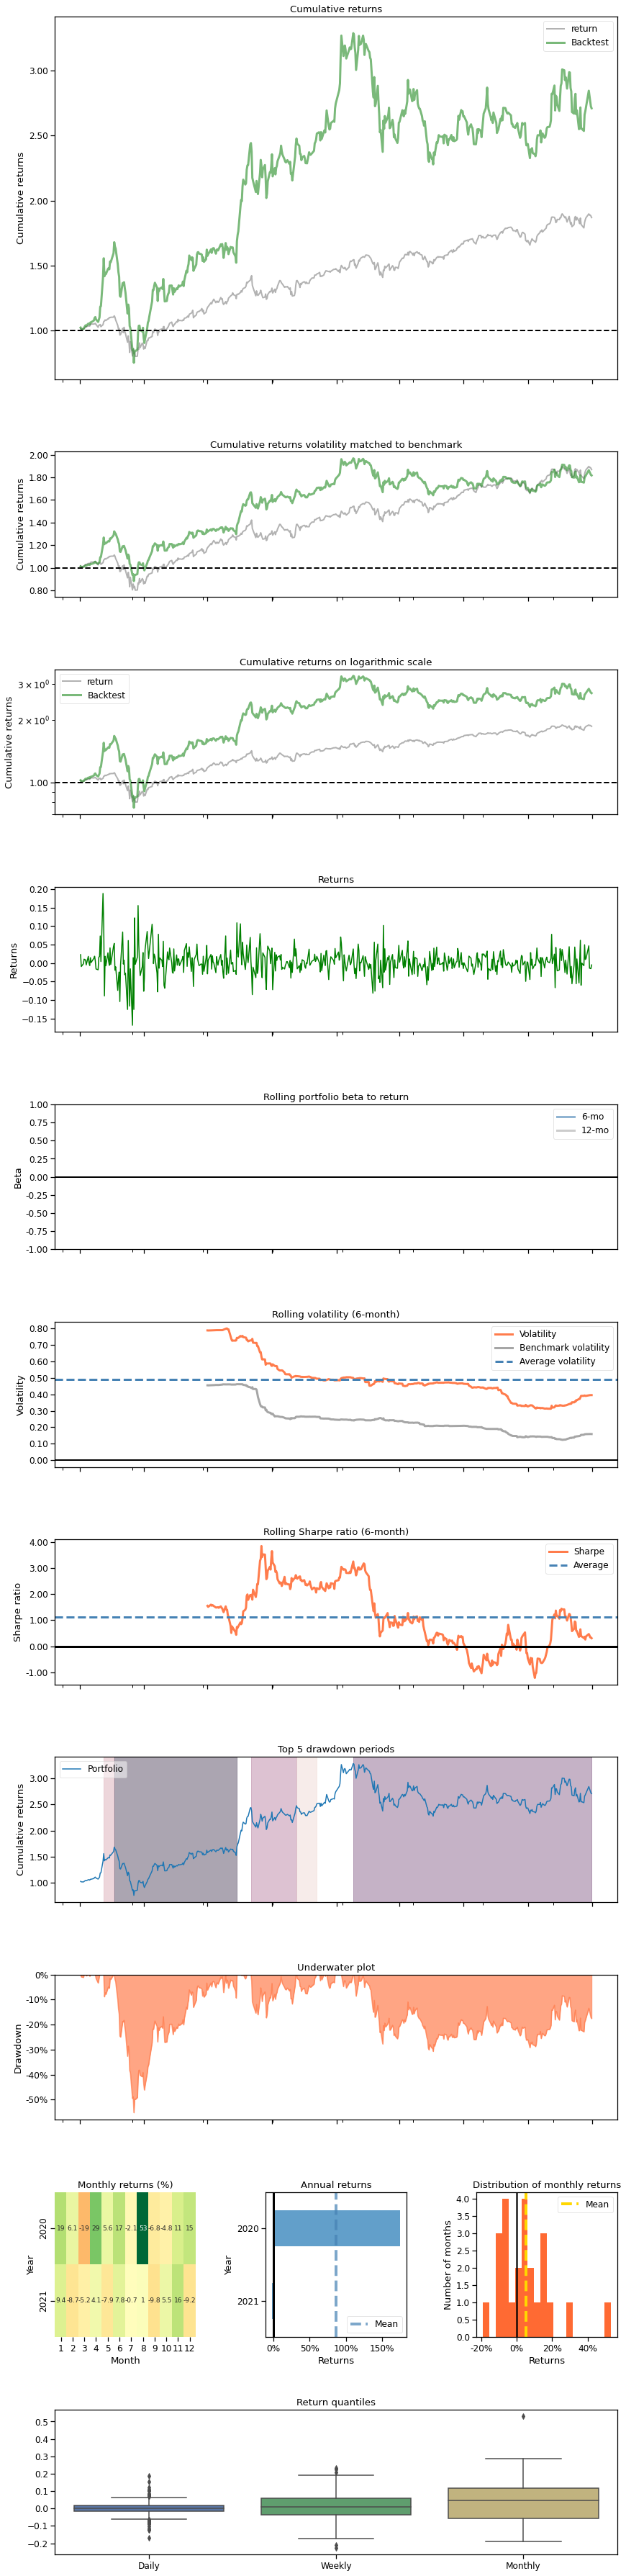

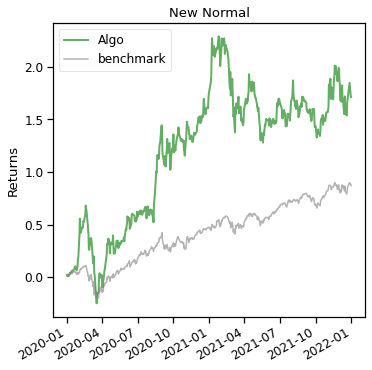

In [22]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = dynamic_r['return'],
                                       benchmark_rets=baseline['return'], set_context=False)

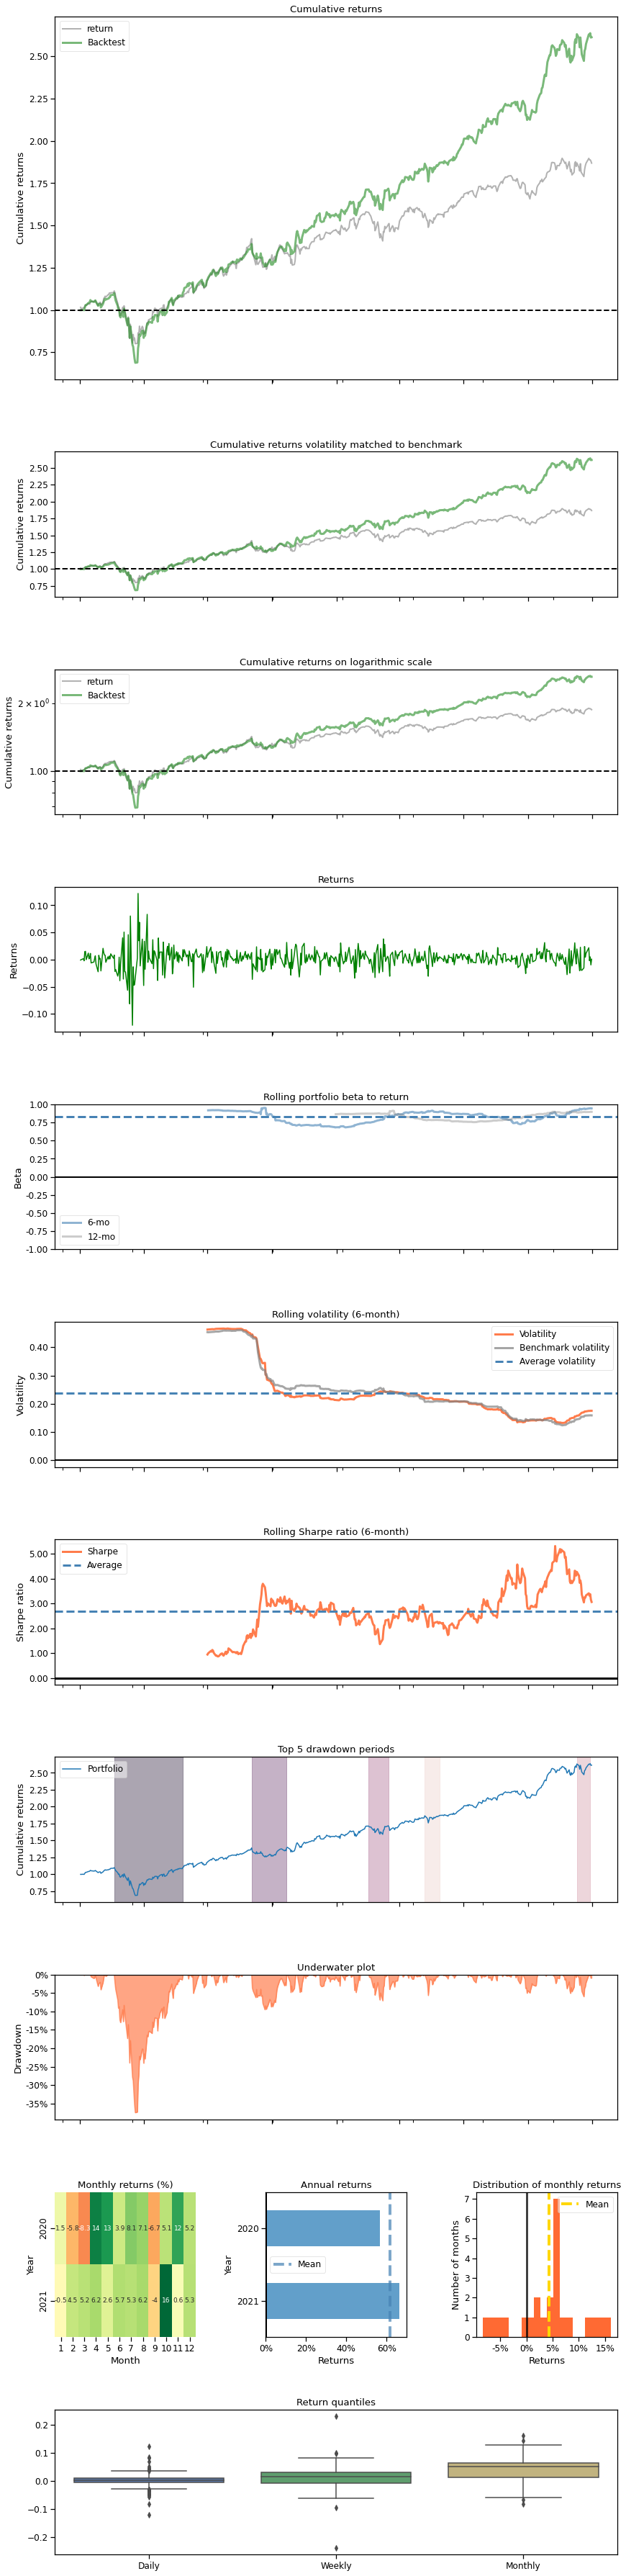

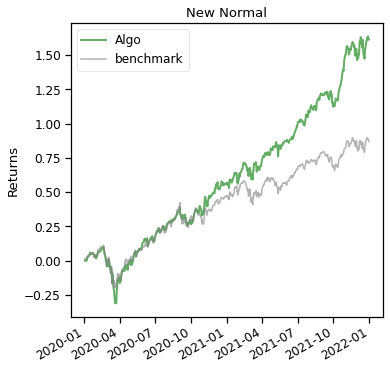

In [24]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = fixed_r['return'],
                                       benchmark_rets=baseline['return'], set_context=False)